In [581]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.patches import ConnectionPatch

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import networkx as nx

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize 

import calendar
import datetime
import pytz
import re
import string
from collections import Counter
from scipy import stats

from tweet_grabber import grab_all_tweets

In [6]:
register_matplotlib_converters()

### Previously on Keeping up with the Kardashians:

<b>Downloading Kim's entire twitter history.</b>

Since the Twitter API only allows for the scraping of the last ~3500 or so tweets, Python's "Get Old Tweets" module was used to to download all of Kim's tweets and save them to a csv file:

<hr>

Creating a new csv file with all available tweets:

```python
grab_all_tweets(usr_name='KimKardashian', n=0, 
                filename='allkim.csv', mode='w')
```

Appending new tweets to the file:

```python
grab_all_tweets(usr_name='KimKardashian', n=0, 
                filename='allkim.csv', mode='a', 
                date_since="2019-07-22")
```
<hr>

This gold mine gives us access to ALL of Kim's tweets since the inception of her Twitter account on March 21st, 2009 when she tweeted:


<img src="screenshots/Kim_first_tweet.png" width="450" alt="Kim's first tweet" title="Kim's first tweet" align="center"/>

A true legend. 

Let's take a closer look at her twitter activities over the course of her career.

In [7]:
pd.set_option('display.max_colwidth', 200)

df = pd.read_csv("allkim.csv", sep=',').drop(columns = ['username', 'geo', 'id'])
df = df.replace('NaN', np.nan)

"""
converting the "date" values to timezone-aware datetime objects 
(Tweet timestamps are set to UTC by default) 
and convert them to Calabasas time aka US/Pacific time, 
since that is Kim's timezone:
"""

times = pd.to_datetime(df['date'], utc=True) 
df['date'] = pd.Index(times).tz_convert('US/Pacific')

"""
because we're hopefully constantly updating our csv file, 
we are sorting our df by date and reset the index,
so the newest tweets will appear on top:
"""

df.sort_values(by=['date'], inplace=True, ascending=False)
df.reset_index(drop=True, inplace=True)

df.head(3)

,date,retweets,favorites,text,mentions,hashtags,permalink
0,2019-09-14 23:18:43-07:00,90,2358,Happy Birthday @itsKELSEYtho I hope you really had the best birthday!!!!,@itsKELSEYtho,NaN,https://twitter.com/KimKardashian/status/1173118930811899904
1,2019-09-14 07:09:51-07:00,4389,58955,I’m so happy you’re coming home! You soooo deserve this!pic.twitter.com/uqYU8p7fau,NaN,NaN,https://twitter.com/KimKardashian/status/1172875109360701442
2,2019-09-13 22:05:28-07:00,130,2664,Embraced By the Light By Betty J Eadiehttps://twitter.com/madridmontoya/status/1172715537614303232 …,NaN,NaN,https://twitter.com/KimKardashian/status/1172738108493848576


So far, we're doing <i>amazing</i>. 

Since we might want to do some sentiment analysis and/or wordclouds (fun!) later on, we begin by cleaning Kim's data, removing urls, numbers, RTs. 

Let's first create a "clean" copy of our dataframe. 

For comparison purposes, we will only keep the text column and keep on adding new columns 
with every step of our cleaning process. That way, we will better be able to see 
what is actually happening. 

In [8]:
clean = df.copy()

def cleanse_tweets(data):
    
    # adding empty 'cleaned' column to df to which cleaned tweets will be written
    data["cleaned"] = ""
    
    for index, row in data.iterrows():
        tweet = str(row['text'])
        
        # removing RTs - we only want pure Kim content to catch a glimpse into her soul 
        # this is important mostly for older tweets before the introduction of the
        # "retweet and comment" feature in 2015 when retweets were done manually  
        tweet = re.sub("\s*RT\s*@[^:].*","",tweet)
        
        # removing @mentions and #-characters (keeping the word/tag itself tho)
        tweet = re.sub("@[A-Za-z0-9_]+","",tweet) 
        tweet = re.sub("#","",tweet)  
        
        # removing some typical urls
        tweet = re.sub("(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*","",tweet)
        tweet = re.sub("pic\.twitter\.com\S*\s?","",tweet)
        tweet = re.sub("bit\.ly.*\s?","",tweet)
        tweet = re.sub("instagr\.am.*\s?","",tweet)
        tweet = re.sub("t\.co.*\s?","",tweet) 
        tweet = re.sub("twitter\.com.*\s?","",tweet)
        tweet = re.sub("[\w/\-?=%.]+\.[\(com)/\-?=%.]+", "", tweet) # removes .com urls without http or www
        
        # removing all numbers and also times (i.e. "12 PM PST"), 
        # since Kimberly likes to announce product drops and also when KUWTK is on
        tweet = re.sub(r"[0-9]+\s*([AaPp][Mm])?\s*([Pp][Ss][Tt])?\s*", "", tweet)
        tweet = re.sub("\…", "", tweet)
        
        # substituting ’ with a regular ' since it is not properly detected otherwise
        tweet = re.sub("’","'",tweet)
        
        # miss me with that punctuation Kim
        tweet  = "".join([char for char in tweet if char not in string.punctuation]) 
        
        # make it all lower case
        tweet = tweet.lower()
        
        # placing cleaned tweet into 'cleaned' column which we created earlier
        data.at[index, 'cleaned'] = tweet


cleanse_tweets(clean)

# removing all rows where only an empty string or a single space remained
clean = clean[(clean['cleaned'] != " ") & (clean['cleaned'] != "")]

On to tokenizing and lemmatizing.

Tokenization basically turns each tweet into a list with each word being an individual item (= token). 
Lemmatization removes inflection and basically returns the "dictionary form" of a word and it works better if the lemmatizer knows whether it is looking at a verb or a noun or an adjective, obviously.

Since the WordNetLemmatizer (which we'll use to lemmatize Kim's tweets) works more accurately if we also tell it the part of speech tag of a word (verb, adverb, noun, etc.), we're going to feed that to her also. 
First tho, we need to convert the pos tags nltk.pos_tag() uses (treebank tags, since it was trained on the Treebank corpus) to the kinds of tags the WordNetLemmatizer understands.

In [9]:
# This is the function we'll use for converting the pos tags:

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'  # returning 'n' here because it's the default tag which we'll fall back on in that case


# our actual lemmatization function, 
# which 1.) tokenizes, 2. pos-tags, and 3.) lemmatizes a tweet:

def tokenize_lemmatize(tweet):
    
    wn = nltk.WordNetLemmatizer()
    
    lemmatized_tweet = []
    
    tokens = nltk.word_tokenize(tweet) # list with individual words as items
    tagged = nltk.pos_tag(tokens) # returns a list of (word, tag)-tuples
    
    for item in tagged:
        word = item[0]
        tag = item[1]
        lemmatized = wn.lemmatize(word, pos=get_wordnet_pos(tag))
        lemmatized_tweet.append(lemmatized)
        
    return lemmatized_tweet


# We're also filtering out stop words like literal trash, ugh #relatable

def remove_stopwords(tweet):
    stop_words = stopwords.words('english')
    more_noise = ['i’m', "im", "w", "u"]
    stop_words.extend(more_noise)

    # first condition removes stopwords, second condition removes empty strings 
    tweet = [word for word in tweet if word.lower() not in stop_words and word]
    return tweet

In [10]:
lemmatized = [tokenize_lemmatize(tweet) for tweet in clean['cleaned']]
stopwords_removed = [remove_stopwords(tweet) for tweet in lemmatized]
clean['lemmatized'] = stopwords_removed
clean.head(3)

,date,retweets,favorites,text,mentions,hashtags,permalink,cleaned,lemmatized
0,2019-09-14 23:18:43-07:00,90,2358,Happy Birthday @itsKELSEYtho I hope you really had the best birthday!!!!,@itsKELSEYtho,NaN,https://twitter.com/KimKardashian/status/1173118930811899904,happy birthday i hope you really had the best birthday,"[happy, birthday, hope, really, best, birthday]"
1,2019-09-14 07:09:51-07:00,4389,58955,I’m so happy you’re coming home! You soooo deserve this!pic.twitter.com/uqYU8p7fau,NaN,NaN,https://twitter.com/KimKardashian/status/1172875109360701442,im so happy youre coming home you soooo deserve this,"[happy, youre, come, home, soooo, deserve]"
2,2019-09-13 22:05:28-07:00,130,2664,Embraced By the Light By Betty J Eadiehttps://twitter.com/madridmontoya/status/1172715537614303232 …,NaN,NaN,https://twitter.com/KimKardashian/status/1172738108493848576,embraced by the light by betty j eadie,"[embrace, light, betty, j, eadie]"


Stemming is different to Lemmatization in the approach it uses to produce root forms of words. 

Stems are created by removing the suffixes or prefixes used with a word. Let's look at some different stemmers to see whether we need stemming and if yes, which stemmer we should use.

I chose to go with three of the most popular stemmers within nltk: 
<ul>
    <li>PorterStemmer</li> 
    <li>LancasterStemmer</li>  
    <li>SnowballStemmer</li>
    
</ul> ... the first one supposedly being less aggressive than the latter two in their... chopping intensity.

In [11]:
stem = pd.DataFrame(clean['lemmatized'])

def ps_stemming(tweet):
    ps = nltk.PorterStemmer()
    tweet = [ps.stem(word) for word in tweet]
    return tweet


stemmed = [ps_stemming(tweet) for tweet in stem['lemmatized']]
stem["PorterStemmer"] = stemmed


def ls_stemming(tweet):
    ls = nltk.LancasterStemmer()
    tweet = [ls.stem(word) for word in tweet]
    return tweet
 

stemmed = [ls_stemming(tweet) for tweet in stem['lemmatized']]
stem["LancasterStemmer"] = stemmed


def ss_stemming(tweet):
    ss = nltk.SnowballStemmer('english')
    tweet = [ss.stem(word) for word in tweet]
    return tweet
 

stemmed = [ls_stemming(tweet) for tweet in stem['lemmatized']]
stem["SnowballStemmer"] = stemmed

# Let's look at the first 10 results to see what we're dealing with
stem.head(10)

,lemmatized,PorterStemmer,LancasterStemmer,SnowballStemmer
0,"[happy, birthday, hope, really, best, birthday]","[happi, birthday, hope, realli, best, birthday]","[happy, birthday, hop, real, best, birthday]","[happy, birthday, hop, real, best, birthday]"
1,"[happy, youre, come, home, soooo, deserve]","[happi, your, come, home, soooo, deserv]","[happy, yo, com, hom, soooo, deserv]","[happy, yo, com, hom, soooo, deserv]"
2,"[embrace, light, betty, j, eadie]","[embrac, light, betti, j, eadi]","[embrac, light, betty, j, eady]","[embrac, light, betty, j, eady]"
3,"[awww, thank]","[awww, thank]","[awww, thank]","[awww, thank]"
4,"[omg, next, episode, cant, handle]","[omg, next, episod, cant, handl]","[omg, next, episod, cant, handl]","[omg, next, episod, cant, handl]"
5,"[kkwxwinnie, collab, available, shop]","[kkwxwinni, collab, avail, shop]","[kkwxwinnie, collab, avail, shop]","[kkwxwinnie, collab, avail, shop]"
6,"[body, collection, back, shop, body, foundation, body, brush, liquid, shimmer, loose, powder, shimmer]","[bodi, collect, back, shop, bodi, foundat, bodi, brush, liquid, shimmer, loos, powder, shimmer]","[body, collect, back, shop, body, found, body, brush, liquid, shim, loos, powd, shim]","[body, collect, back, shop, body, found, body, brush, liquid, shim, loos, powd, shim]"
7,"[body, collection, restock, today]","[bodi, collect, restock, today]","[body, collect, restock, today]","[body, collect, restock, today]"
8,"[senator, meet, capitol, please, support, aca]","[senat, meet, capitol, pleas, support, aca]","[sen, meet, capitol, pleas, support, ac]","[sen, meet, capitol, pleas, support, ac]"
9,"[cant, keep, tell, people, work, pay, tax, try, raise, family, cant, vote, theyre, parole, people, serve, time, try, rebuild, life, opportunity, voice, hear, election]","[cant, keep, tell, peopl, work, pay, tax, tri, rais, famili, cant, vote, theyr, parol, peopl, serv, time, tri, rebuild, life, opportun, voic, hear, elect]","[cant, keep, tel, peopl, work, pay, tax, try, rais, famy, cant, vot, theyr, parol, peopl, serv, tim, try, rebuild, lif, opportun, voic, hear, elect]","[cant, keep, tel, peopl, work, pay, tax, try, rais, famy, cant, vot, theyr, parol, peopl, serv, tim, try, rebuild, lif, opportun, voic, hear, elect]"


At first glance it looks like PorterStemmer really is less aggressive: 

While LS and SS turned love into <i>lov</i>, family into famy, fire into fir, brother to broth and powder to powd, the PS was not quite as harsh. It turns body into bodi and episode into episod tho and I feel like that is just not necessary for us since since we want to look at the actual words Kim blesses us with.

Let's go back to our previous "clean" dataframe and take a look at our data so far.

In [12]:
# let's compare our cleaned data with the original data in terms of numbers 
# by plotting the yearly tweet amount bars side by side

# function for chopping the dataframe up into years
def yearly_dfs(start, end, frame, string="k"):
    """
    chops dataframe into smaller dataframes based on the year of the tweets.
    :param start: = first year (will be included)
    :param end: = last year (will be included)
    :param frame: = dataframe to be chopped up    
    
    returns:
    years - list of years (int) with start being the first item and end the last
    frames - list of dataframes with each frame containing the tweets for one calendar year
    """
    years = np.arange(start, end+1, 1)
    frames = []
    for year in years:
        # resetting index so that the individual frames will be easier to work with later
        # old index will be added as a column, so we will still be able to see the og index
        dataframe = frame[frame['date'].dt.year == year].reset_index() 
        frames.append(dataframe)
        
    return years, frames

In [13]:
# this is our uncleaned data, the original k
# individual dataframes for each year based on the original dataframe

years, frames = yearly_dfs(start=2009, end=2019, frame=df)

k2009 = frames[0]
k2010 = frames[1]
k2011 = frames[2]
k2012 = frames[3]
k2013 = frames[4]
k2014 = frames[5]
k2015 = frames[6]
k2016 = frames[7]
k2017 = frames[8]
k2018 = frames[9]
k2019 = frames[10]

yearly_tweets = np.array([len(k2009), len(k2010), len(k2011), len(k2012), len(k2013), 
           len(k2014), len(k2015), len(k2016), len(k2017), len(k2018), len(k2019)])


# this is our cleaned data
_, clean_frames = yearly_dfs(2009, 2019, frame=clean, string="clean")

clean2009 = clean_frames[0]
clean2010 = clean_frames[1]
clean2011 = clean_frames[2]
clean2012 = clean_frames[3]
clean2013 = clean_frames[4]
clean2014 = clean_frames[5]
clean2015 = clean_frames[6]
clean2016 = clean_frames[7]
clean2017 = clean_frames[8]
clean2018 = clean_frames[9]
clean2019 = clean_frames[10]

cleaned_yearly_tweets = np.array([len(clean2009), len(clean2010), len(clean2011), 
                                  len(clean2012), len(clean2013), len(clean2014), 
                                  len(clean2015), len(clean2016), len(clean2017), 
                                  len(clean2018), len(clean2019)])

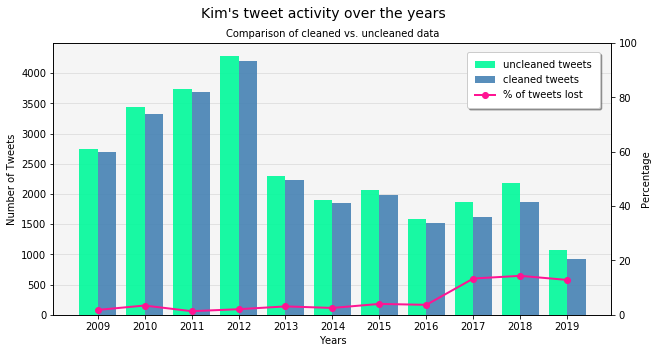

In [589]:
# let's plot!
title = "Kim's tweet activity over the years"
n_groups = len(years)
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.9

fig = plt.figure(figsize=(10,5))
fig.suptitle(title, size=14)
ax1 = fig.add_subplot(111)

unclean_bars = ax1.bar(np.array(index), yearly_tweets, 
                 bar_width, alpha=opacity, color='mediumspringgreen', 
                       label='uncleaned tweets', zorder=2)

clean_bars = ax1.bar(np.array(index + bar_width), cleaned_yearly_tweets, 
               bar_width, alpha=opacity, color='steelblue', 
                     label='cleaned tweets', zorder=2)

ax1.set_xlabel('Years')
ax1.set_ylabel('Number of Tweets')
ax1.set_title("Comparison of cleaned vs. uncleaned data", size=10)
ax1.set_facecolor('whitesmoke')
ax1.grid(axis='y', color='gainsboro', zorder=1)

# cloning the x-axis for plot showing lost tweet percentage
ax2 = ax1.twinx()
ax2.set_ylim((0,100))
ax2.set_ylabel('Percentage')

# data
percent_lost = np.array([100*(1-(cleaned_yearly_tweets / yearly_tweets))]).reshape((11, 1))
ax2.plot(index+0.5*bar_width, percent_lost, 
                   c='deeppink', label="% of tweets lost", 
                   linewidth=2, marker="o", markersize=6)
plt.xticks(index + 0.5*bar_width, years, rotation=0)
fig.legend(loc='upper right', bbox_to_anchor=(0.84, 0.85), borderpad=.8, shadow=True)

plt.show()

#### Comparison of cleaned vs. uncleaned data

As we can see, the changes are not too dramatic. But some tweets had to be given up, especially in more recent years:

We can safely assume that those lost tweets are im most cases <em>url-only tweets</em> (including image url-only) or <em>pre-2015 retweets</em> with no commentary added by Kimberly herself (pre-2015, retweeting was done manually)
Those tweets that do not contain words by Kim herself were removed from the dataframe as ruthlessly as Jordyn Woods was removed from Kylie's house after the Tristan Thompson "incident" in the spring of 2019.

We can see that the percentage of removed tweets is increasing drastically in 2017 while her overall tweet numbers have been somewhat stagnant/declining ever since that huge drop in 2013. (Obviously, our 2019 data is incomplete still.) One possible explanation: In 2017 she launched both her beauty line, KKW Beauty, and her fragrance line, KKW Fragrance. Both of these lines she heavily promotes on twitter, often times posting only urls or pics of her products, which have been eliminated during our cleaning process. <em>This needs to be explored further.</em>

It's very obvious that Kim's twitter usage has changed over the years even by just looking at the numbers. There are a couple of very important questions that need to be answered. The first one that immediately comes to mind looking at those bars:

<b>What was 2012 about?</b> 

Obviously Kim had lots to say in 2012... but after that, not so much. What happened? We know that she met Kanye in 2012, which was a huge change for her personally but also for her career and her branding, as <a href="https://crybabyzine.com/2019/08/theories-of-the-kardashians/">Crybaby Magazine</a> put it: <em>"Kim’s gaudy LA-princess aesthetic elevated to something haute and post-modern"</em>. With their relationship came a complete overhaul of her brand. So we will of course try to look into how her twitter behaviour might have changed with the ascendence of Kanye as well.

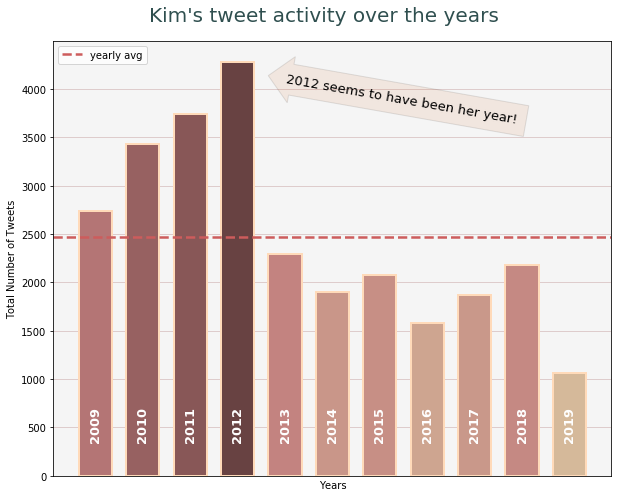

In [15]:
'''
For graphs looking only at numbers it's obviously better to use the original data
since we don't want those tweets to be discarded. They were tweets after all.

Let's make a prettier graph with colors that look like KKW lipsticks lol
'''

# Colorizing the bars based on tweet amount:
scores = np.array(yearly_tweets) # setting scale for measuring progression steps on the cmap
data_normalizer = matplotlib.colors.Normalize() # normalizing data into [0.0, 1.0] interval
colormap = matplotlib.cm.get_cmap('pink_r', 512) # getting a colormap from mlp
newcmp = ListedColormap(colormap(np.linspace(0.45, 0.9, 256))) # reduce range by slicing cmap
colors = newcmp(data_normalizer(scores))

fig = plt.figure(figsize=(10,8))
fig.suptitle(title, fontsize=20, color='darkslategrey', y=0.94)

ax = fig.add_subplot(111)
bars = ax.bar(years, yearly_tweets, color=colors, width=.7, 
              zorder=2, ec='peachpuff', linewidth=2, linestyle="-")
ax.set_xlabel("Years")
ax.set_ylabel("Total Number of Tweets")
ax.set_facecolor("whitesmoke")
plt.grid(axis="y", color="rosybrown", alpha=.4, zorder=1, linewidth=1)

# adding a horizontal line for yearly average
mean = np.mean(yearly_tweets)
ax.axhline(mean, c="indianred", label="yearly avg", 
            linewidth=2.5, linestyle="dashed")
ax.legend(loc="upper left")

# annotate
annotaish = "2012 seems to have been her year!"
bbox_props=dict(boxstyle="larrow", pad=0.7, fc="chocolate", alpha=0.1, lw=1)
arrow_props=dict(facecolor='palevioletred', ec='rosybrown', shrink=0.05)
ax.annotate(annotaish, xy=(2013,3650), xycoords='data', rotation=-10,
             size=13, bbox=bbox_props)


# adding the years as text on each bar instead of using x-ticks
ax.set_xticks([])
bars = ax.patches
for index, bar in enumerate(bars):
    (y_bottom, y_top) = ax.get_ylim()
    xloc = years[index]
    yloc = y_bottom + 380
    ax.text(xloc, yloc, str(xloc), color="w", size=13, 
            fontweight="demibold", rotation=90, ha="center")

plt.show()

Let's take a deep-dive into Kim's 2012 on Twitter since it is her most active year to date.
It is also an interesting point in her career: In 2012, Kim was definitely already pretty famous (Keeping up with the Kardashians premiered aired 7th season that year), but she had not quite manifested her brand in the way that she has nowadays. She also, after her separation from Kris Humphries in Oct. 2011, starts dating Kanye in the spring of 2012, getting pregnant in the fall that same year. The ascendance of Kanye will have a huge impact on her brand later on, so we will peek into Kim's Twitter just before these changes start to manifest... 

First, let's create a bunch of cute looking charts and come back later to see what we can gather from the data.

In [16]:
# These are some helper functions we'll use in our chart design later on:

def autolabel(rects, ax):
    """
    function for labeling bars with their y values
    
    rects = ax.patches
    ax = axes object on which the bar chart to be labeled is placed
    """
    
    # get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95: # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.06)
            
        else:
            label_position = height - (y_height * 0.06)
            # label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%d' % int(height), color="#edf8fb", fontweight="semibold",
                size="x-large", ha='center', va='bottom')


def hbar_labeler(ax, bars, label_list, x_offset=0.3):
    """
    function for labeling horizontal bars
    
    ax = axes object on which the barh chart to be labeled is placed
    bars = the barh object (i. e. bars = ax1.barh())
    label_list = list of strings containing the labels to be put on the bars
    x_offset = offset on the x-axis (size of gap between y-axis and left border of the label)
    """
    
    for index, bar in enumerate(bars):
        ax.text(bar.get_x()+x_offset, bar.get_y()+0.16, label_list[index], 
                 color="#7A0475", size=11, weight="semibold", stretch="condensed", 
                 ha='left', va='bottom')

        
def make_autopct(values):
    """
    function to pass into plt.pie(autopct=) 
    to label wedges of pie chart with values and percentages
    (taken from matplotlib docs) 
    """
    
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} days\n ({p:.2f}%)'.format(p=pct,v=val)
    return my_autopct

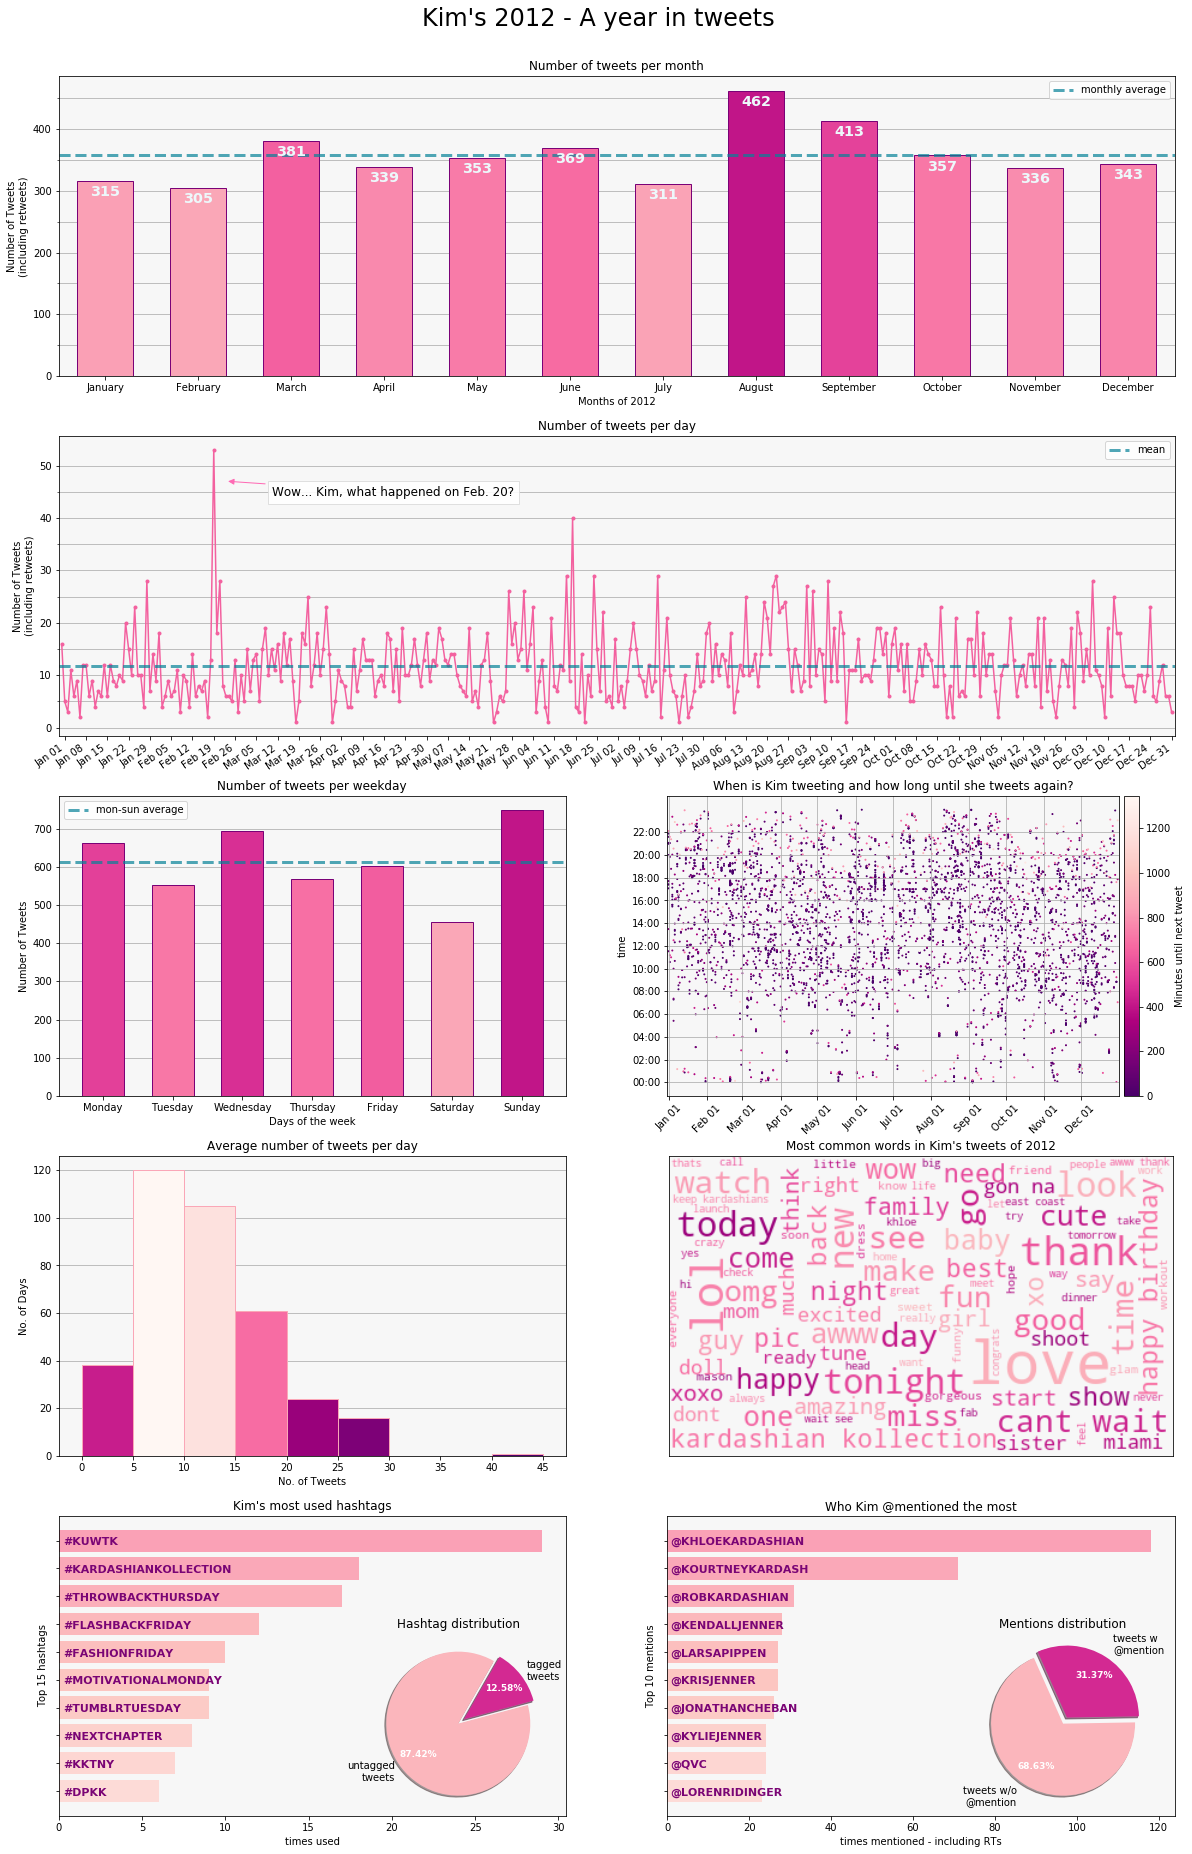

In [17]:
# This is where the code for our 2012 Kim mega chart begins

title = "Kim's 2012 - A year in tweets"
bg_color = "#f7f7f7"
linecolor = "#078298"
fig = plt.figure(figsize=(20,32))
fig.suptitle(title, size=24, y=0.91)

# using subplot2grid to create all our axes
ax1 = plt.subplot2grid((5, 2), (0, 0), colspan=2) # monthwise tweet distribution bars
ax2 = plt.subplot2grid((5, 2), (1, 0), colspan=2) # daywise tweet distribution bars
ax3 = plt.subplot2grid((5, 2), (2, 0))            # weekday distribution bar 
ax4 = plt.subplot2grid((5, 2), (2, 1))            # daily tweet hours scatter plot
ax5 = plt.subplot2grid((5, 2), (3, 0))            # histogram of avg no of tweets per day
ax6 = plt.subplot2grid((5, 2), (3, 1))            # wordcloud of her 2012 tweets
ax7 = plt.subplot2grid((5, 2), (4, 0))            # most used hashtags hbars 
ax7a = fig.add_axes([0.34, 0.115, 0.125, 0.10])   # tiny pie, pct of hashed/unhashed tweets 
ax8 = plt.subplot2grid((5, 2), (4, 1))            # most mentions hbars 8
ax8a = fig.add_axes([0.76, 0.115, 0.125, 0.10])   # tiny pie, pct of mention/non-mentions 

# setting the facecolor for all the axes
for ax in fig.axes:
    ax.set_facecolor(bg_color)

# ... and giving them titles
ax1.set_title("Number of tweets per month")
ax2.set_title("Number of tweets per day")
ax3.set_title("Number of tweets per weekday")
ax4.set_title("When is Kim tweeting and how long until she tweets again?")
ax5.set_title("Average number of tweets per day")
ax6.set_title("Most common words in Kim's tweets of 2012")
ax7.set_title("Kim's most used hashtags")
ax7a.set_title("Hashtag distribution")
ax8.set_title("Who Kim @mentioned the most")
ax8a.set_title("Mentions distribution")


'''
ax1: bar chart showing Kim's monthly tweet distribution
'''
# ax1 data
m = Counter(k2012['date'].sort_values().dt.month)
months = [item for item in m]
month_nums = list(m.values())
monthlabels=list(calendar.month_name)[1:]

# color settings - Colorizing the x bars based on y values:
scores = np.array(month_nums) # setting scale to measure progression steps on the cmap
data_normalizer = matplotlib.colors.Normalize() # normalizing data to [0.0, 1.0] interval
colormap = matplotlib.cm.get_cmap('RdPu', 512) # getting colormap from mlp
newcmp = ListedColormap(colormap(np.linspace(0.35, 0.7, 256))) # reduce range by slicing cmap
colors = newcmp(data_normalizer(scores))

# ax1 chart
ax1.bar(monthlabels, month_nums, width=0.6, zorder=2, color=colors, ec='#7a0177')
ax1.set_xlim((-0.5, 11.5))
ax1.set_xticklabels(monthlabels)
mean = np.mean(month_nums)
ax1.axhline(y=mean, label="monthly average", color=linecolor, 
            linestyle="dashed", linewidth=3, alpha=.7)
ax1.set_yticks(np.arange(0,500,50), minor=True)
ax1.grid(axis='y', zorder=1, which='both')
ax1.legend()
ax1.set_xlabel("Months of 2012")
ax1.set_ylabel("Number of Tweets\n(including retweets)")
rects = ax1.patches 
autolabel(rects, ax1)


'''
ax2 daily tweet distribution
'''
# ax2 data
d = Counter(k2012['date'].sort_values().dt.strftime('%B %d'))
days = [item for item in d]
day_nums = list(d.values()) #[d[item] for item in d]

# ax2 chart
ax2.set_facecolor(bg_color)
ax2.plot(days, day_nums, color='#F3619F', zorder=2, marker=".")
ax2.axhline(y=np.mean(day_nums), label="mean", color=linecolor, 
            linestyle="dashed", linewidth=3, alpha=.7)
ax2.set_xlim((-1, 366))
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.set_xticks(np.arange(1,366,7))

# setting rotation and alignment of the labels:
for label in ax2.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(35)

ax2.set_yticks(np.arange(0,50,5), minor=True)
ax2.grid(axis='y', zorder=1, which='both')
ax2.legend()
ax2.set_ylabel("Number of Tweets\n(including retweets)")

# ax2 annotation
ax2comment = "Wow... Kim, what happened on Feb. 20?"
bbox_props=dict(boxstyle="square", pad=0.4, fc="w", alpha=.9, ec="gainsboro", lw=1)
arrow_props=dict(arrowstyle="-|>", facecolor='hotpink', ec='hotpink')
ax2.annotate(ax2comment, xy=(0.15,0.85), xytext=(0.3,0.8), xycoords='axes fraction', 
             size=12, color="k", ha="center", arrowprops=arrow_props, bbox=bbox_props)


'''
ax3 weekday tweet distribution
'''
# ax3 data
weekdays = list(calendar.day_name)
weekday_tweets_2012 = [] # list w/ len of each frame = total num of tweets for each weekday
for index in range(len(weekdays)):
    # .dt.weekday returns weekday (0=Monday...) 
    # thus creating a frame for each weekday. 
    # we're only storing the length aka total number of tweets
    dayframe = k2012[k2012['date'].dt.weekday == index].reset_index()
    weekday_tweets_2012.append(len(dayframe))

# color settings - Colorizing the x bars based on y values:
ax3_scores = np.array(weekday_tweets_2012) 
data_normalizer = matplotlib.colors.Normalize() 
colormap = matplotlib.cm.get_cmap('RdPu', 512) 
newcmp = ListedColormap(colormap(np.linspace(0.35, 0.7, 256))) 
ax3colors = newcmp(data_normalizer(ax3_scores))

# ax3 chart
ax3.bar(weekdays, weekday_tweets_2012, width=0.6, zorder=2, color=ax3colors, ec='#7a0177')
ax3.set_xticklabels(weekdays)
mean = np.mean(weekday_tweets_2012)
ax3.axhline(y=mean, label="mon-sun average", color=linecolor, 
            linestyle="dashed", linewidth=3, alpha=.7)
ax3.grid(axis='y', zorder=1, which='both')
ax3.legend()
ax3.set_xlabel("Days of the week")
ax3.set_ylabel("Number of Tweets")


'''
ax4 scatterplot of times of the day she tweeted over the year
'''
# ax4 data 
x_days = k2012['date'].sort_values().dt.date
alltimes = k2012['date'].sort_values().dt.strftime('%H:%M')
y_times = [datetime.datetime.strptime(t, '%H:%M').time() for t in alltimes]

# data for colorbar gradient - figuring out timedelta between tweet and next tweet
timeit = k2012['date'].sort_values().tolist()
minutes = []
for index, time in enumerate(timeit):
    next_index = (index + 1) % len(k2012)
    # when last date in 2012 is reached, first date of 2013 is used to create the delta
    if next_index == 0:
        delta = k2013["date"].sort_values().tolist()[0] - time
    # looking at next time and creating a delta (= how long until the next tweet)
    else:  
        delta = timeit[next_index] - time     
    m = delta.seconds / 60
    minutes.append(int(m))

# settings for colorbar
max_value = max(minutes)
min_value = min(minutes)
ax4_cmap = plt.get_cmap('RdPu_r')
norm = matplotlib.colors.Normalize(vmin=min_value,vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=ax4_cmap, norm=norm)
sm.set_array([])
# adding the colorbar: 
cbar = fig.colorbar(sm, ax=ax4, label="Minutes until next tweet", fraction=0.1, pad=0.01)

# ax4 chart
scatter = ax4.scatter(x_days, y_times, s=1, c=minutes, cmap="RdPu_r")
ax4.set_facecolor(bg_color)
ax4.set_xlim([datetime.date(2011, 12, 31), datetime.date(2013, 1, 1)])
firsts = [datetime.date(2012, i, 1) for i in range(1,13)]
ax4.set_xticks(firsts)
y_tick_times = [f"{a:02d}:00:00" for a in range(24) if a%2==0] # list of times for y axis
ax4.set_yticks(y_tick_times)
ax4.set_xticklabels(firsts, rotation=45)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax4.grid(axis='both', zorder=1, which='both')


''' 
ax5: histogram of the number of tweets she sent out
'''
# ax5 data
tweet_amount_bins = np.arange(0,50,5)
# colormap
hist_cm = plt.cm.get_cmap('RdPu_r')
# ax5 chart
n, bins, patches = ax5.hist(day_nums, bins=tweet_amount_bins, zorder=2, ec="#FAA7B7")
ax5.set_xlabel("No. of Tweets")
ax5.set_ylabel("No. of Days")
ax5.set_xticks(tweet_amount_bins)
ax5.grid(axis="y", zorder=1)
hist_col = (n-n.min())/(n.max()-n.min())
for color, patch in zip(hist_col, patches):
    plt.setp(patch, 'facecolor', hist_cm(color))


''' 
ax6 wordcloud for all 2012 tweets
'''
# ax6 data    –    using the cleaned tweets for this 
lemmatized_2012_tweets = clean2012['lemmatized'].tolist()
# because each lemmatized tweet is its own list, a nested loop joins them all together:
tweet_string_2012 = " ".join(word for tweet in lemmatized_2012_tweets for word in tweet)
# colormap settings:
wordcloud_cmap = matplotlib.cm.get_cmap('RdPu', 512) 
new_wc_cmp = ListedColormap(colormap(np.linspace(0.3, 0.8, 256)))
# generating the word cloud: 
cloudy = WordCloud(height=250, width=420, 
                   max_font_size=50, max_words=100, 
                  colormap=new_wc_cmp, 
                   background_color=bg_color).generate(tweet_string_2012)

# ax6 chart
ax6.imshow(cloudy, interpolation='bilinear')
ax6.set_xticks([])
ax6.set_yticks([])

    
'''
ax7: horizontal bars of her fav hashtags and
ax7a: pie of hashtag vs non-hashtag tweets
'''
# ax7 data
tagged_tweets_of_2012 = k2012[k2012['hashtags'].notnull()]
hashtag_values_2012 = [tweet.upper() 
                       for tweet in tagged_tweets_of_2012['hashtags'].values.tolist()]
hashtag_list_2012 = [] # list of all hashtags she used in 2012
for string in hashtag_values_2012:
    indiv_tags = string.split()
    for i in range(len(indiv_tags)):
        hashtag_list_2012.append(indiv_tags[i])

hashcounter = Counter(hashtag_list_2012)
bar_hashtags = [i[0] for i in hashcounter.most_common(10)][::-1]
bar_hashamounts = [i[1] for i in hashcounter.most_common(10)][::-1]

# ax7a data
number_of_hashtagged_tweets_2012 = len(tagged_tweets_of_2012) #539
number_of_untagged_tweets_2012 = len(k2012[k2012['hashtags'].isnull()])

# color settings
colors = plt.cm.RdPu(np.linspace(0.15, 0.37, len(bar_hashtags)))
colorspie = plt.cm.RdPu_r(np.linspace(0.35, 0.7, 2))

# ax7 chart
bars = ax7.barh(bar_hashtags, bar_hashamounts, color=colors)
# calling function from above to label bars:
hbar_labeler(ax7, bars, bar_hashtags)
ax7.set_xlabel("times used")
ax7.set_ylabel("Top 15 hashtags")
ax7.set_yticklabels([])

# ax7a chart
w, text, autotext = ax7a.pie([number_of_hashtagged_tweets_2012, 
                              number_of_untagged_tweets_2012], 
                             colors=colorspie, startangle=15, 
                             explode=[0.1,0], shadow=True, 
                             radius=1, labeldistance=1.1,
                             labels=['tagged\ntweets', 'untagged\ntweets'], 
                             autopct='%.2f%%', pctdistance=.7)

for at in autotext:
    at.set_color("w")
    at.set_fontweight("bold")
    at.set_fontsize(9)


'''
ax8 horizontal bar of mentions
'''
# ax8 data
mentions_of_2012 = k2012[k2012['mentions'].notnull()]
# filtering out retweets to get actual mentions 
no_retweets = mentions_of_2012[mentions_of_2012['text'].str.contains("RT ") == False]
mention_values_2012 = [mention.upper() 
                       for mention in no_retweets['mentions'].values.tolist()]
mentions_list_2012 = [] # list of all accts she @mentioned in 2012
for string in mention_values_2012:
    indiv_tags = string.split()
    for i in range(len(indiv_tags)):
        mentions_list_2012.append(indiv_tags[i])

menshcounter = Counter(mentions_list_2012)
bar_mentions = [i[0] for i in menshcounter.most_common(10)][::-1]
bar_mentionamts = [i[1] for i in menshcounter.most_common(10)][::-1]

number_of_mentioned_tweets_2012 = len(no_retweets) 
number_of_unmentioned_tweets_2012 = len(k2012) - number_of_mentioned_tweets_2012

# color settings:
colorsbar = plt.cm.RdPu(np.linspace(0.15, 0.37, len(bar_mentions)))
colorspie = plt.cm.RdPu_r(np.linspace(0.35, 0.7, 2))

# ax8 chart 
bars = ax8.barh(bar_mentions, bar_mentionamts, color=colorsbar)
# calling function from above to label bars
hbar_labeler(ax8, bars, bar_mentions, x_offset=0.8) 
ax8.set_xlabel("times mentioned - including RTs")
ax8.set_ylabel("Top 10 mentions")
ax8.set_yticklabels([])

#ax8a chart
w, text, autotext = ax8a.pie([number_of_mentioned_tweets_2012, 
                              number_of_unmentioned_tweets_2012], 
                             colors=colorspie, startangle=1, 
                             explode=[0.1,0], shadow=True, 
                             radius=1, labeldistance=1.2,
                             labels=['tweets w\n@mention', 'tweets w/o\n@mention'], 
                             autopct='%.2f%%', pctdistance=.7)
for at in autotext:
    at.set_color("w")
    at.set_fontweight("bold")
    at.set_fontsize(9)



# Kim's 2012 – What did we learn so far?
<p>
    First of all, these colors look amazing.
    </p>
    
#### Monthly tweet distribution

<p> August obviously was her strongest month, numbers wise. We'll have to look into that in more detail and see what her likes/tweet ratio looks like and what she talked about every month. But so far, nothing really stands out here. Moving on.
    </p>
    
#### Daily tweet distribution

<p> Looking at the second chart, most of the time, a zig-zag type of pattern seems to emerge: days with a fair amount of tweeting and days with not so many tweets alernate a lot of the time. 
    
Her average amount of tweets looks to be around 12-ish per day. Surprisingly, there are no zero-tweet days in 2012. Very rarely does she go above 30 tweets. Interestingly, in her weakest month, February, she also had her most productive (tweet wise) day of the year by a huge margin, producing more than 50 tweets on February 20th. We're definitely going to have to investigate what went down. 
    </p>
    
#### Weekday wise tweet distribution

<p> Sunday is definitely her favorite day for tweeting... while on Saturday, she likes to stay away. Nothing much to see so far.
    </p>
    
#### Time of day for tweeting – time until the next tweet

<p> This was fun to create, but it is a tiny, tiny mess. We cannot gather anything from this other than the fact that she does not seem to tweet a lot during the night. No surprise there. We might look into this more thoroughly at a later time. 
    </p>
    
#### Average number of tweets per day

<p> Now, this is quite interesting. While we already gathered that she averages about 12 tweets per day, most of the time, she blesses us with 5-10 tweets per day, sometimes up to 15. More than that – well, those days are a rare occurence. While there is nothing in the 30-40 tweets per day area, she did have those very rare days when she went and tweeted more than 40 times. Someone take her... Blackberry away (I guess, since it was 2012).
    </p>

#### Most used words

<p> This wordcloud gives us a good clue about Kim being really into love and into things she likes to lol at. I believe she does not use 'lol' as much today, this would need to be verified tho of course. Obviously, her most used words that year need to be investigated further as well. But we can already see that these words are all rather positive: love, lol, thank, good.
    </p>


#### Most hashtags

<p>
    First of all, her hashtags. 2012 Kim was heavily into weekday-themed hashtags. I will give her a pass on #flashbackfriday and #throwbackthursday. But #tumblrtuesday? Are you serious, Kimberly? I guess, since she only uses hashtags in, like, pretty much exactly an eighth of her tweets, it does not really matter all that much. But we'll def have to check out what she tweeted along with those ridiculous hashtags. Other than those, it's pretty much self promo time, with #kuwtk and #kardashiankollection being the top hashtags, and of course #kktny ("Kourtney and Kim Take New York", a kuwtk spin off airing at the time). Although I would guarantee that today's numbers of using kkw-related hashtags are through the roof and those numbers pale in comparison. </p>
    
#### Most hashtags and most mentions

<p>
    Those mentions are wild, why is she conversing with Khloe so much? It's obvious that Kylie was not a billionaire back then, otherwise she would be much higher up there. Back then they had not given up on Rob, so he is up there of course, and Larsa Pippen and Jonathan Cheban, those two are still around, so no surprises there. QVC is embarassing of course, but I believe they had some sort of collab with them at the time. Of course they would never admit that in public today. Tragic.

She notably mentions someone in almost a third of her tweets which tells us that she really did emphasize the interactive aspect of twitter as a platform at the time. (Retweets are excluded.) We will definitely have to look into how that number changes over the years. 
    </p>
### Further investigations are necessary. Especially into what went down on that 50+ tweet day in February!

In [18]:
feb_20 = k2012[(k2012['date'].dt.month == 2) & (k2012['date'].dt.day == 20)]

# Feb. 20, 2012 – Kim's most productive day of the year
## A tweet-by-tweet investigation

<p>Funnily enough, her last two tweets on Feb. 19 were about how she signed up for an Instagram account - an iconic moment for sure. We already know this will be really important for her twitter day. But first ...
    
### 00:07 AM –  i dont have the time 2 shut them all down
    
Shortly after midnight, in the earliest hour of Feb. 20, after some playful exchanges with fans, it begins:</p>

(pls take note, twitter displays the local time when a tweet was posted. So although these screenshots say 9 am, it was just after midnight Kim's time (PST))

<p>
<img src="screenshots/Kim_feb_20.png" width="400" alt="Kim on Feb. 20" title="Kim on Feb. 20" align="center"/><br/>
<img src="screenshots/Kim_feb_20_1.png" width="400" alt="Kim on Feb. 20" title="Kim on Feb. 20" align="center"/><br/>
<img src="screenshots/Kim_feb_20_2.png" width="400" alt="Kim on Feb. 20" title="Kim on Feb. 20" align="center"/><br/></p>

<p>  
    Some negative story must have broken and Kim went into defense mode, embarassing herself by interacting with non-famouses and replying to and retweeting regular people. Some of them seem to only have asked questions which she replied to, some of them must have said some encouraging words to her.</p>
    
<p>
    Unfortunately, the tweets she replied to have been deleted and google doesn't really tell us much on what went down that day. Probably something minor, since her split from Kris Humphreys happened four months prior, in Oct. 2011, and she does not start dating Kanye until two months later, in April 2012. It's interesting though how she interacted even with her <em>haters</em>, she does not do that at all anymore... I believe today she almost exclusively (if at all) retweets fans who tweet about how much they love her products. Kim, you should know better than to talk to people with less than a million followers and by now, thankfully, you do.</p>
    
<b>Tweet Count: 17</b>

### 08:24 AM – rise & grind
<p>
    Anyway, let's move on from her late-night hater repelling session. After interacting with these non-rich randoms until 12:30 at night, which I assume is pretty tiring, she seems to go to sleep until 8:24 am, when she awoke with a genius idea for an early(-ish) morning tweet which she shares with us immediately: </p>

> rise & grind!

<p>
    As we learn 4 hours later, her grind this morning seems to have consisted of painting her nails, since at 12:05 PM, what we can safely assume is an automated tweet by Instagram appears in her feed, notifying her followers of a pic she has just posted. Let's follow the link (remember: this is one of her first Instagram pics since she only signed up the day before):
    </p>

> Painted my nails with "it's all about the glam" by Nicole by Opi http://instagr.am/p/HPXzyfuS4U/

<img src="screenshots/Kim_feb_20_insta.png" width="550" alt="Kim on Feb. 20" title="Kim on Feb. 20" align="center"/>


<p>
    First of all, Kim, we know you did not paint those nails yourself since if you google "Kim Kardashian Feb. 20, 2012" a bunch of alerts pop up of paparazzi pics of you leaving a nail salon in LA. Second of all, this pose is fucking embarassing, it is very much outdated even in 2012, you should delete this picture and pray that we all forget we ever saw it. But also thank you for not deleting this very important historical document, you are a cultural icon who we all feel very ambivalent about but still obsess over obsessively. </p>

<b>Tweet Count: 19</b>

### 12:09 PM – everyone says I'm gonna be obsessed with instagram
    
<p>
    Immediately after posting her first insta pic of the day, she returns to twitter to continue talking about Instagram, sending out four tweets, one of them another automated Insta tweet, informing us about her next post:</p>

> Ok everyone says I'm gonna be obsessed with instagram do trying this out!

> Testing testing.... Testing out the effects http://instagr.am/p/HPZVl7uS4n/

<img src="screenshots/kim_feb_20_insta_2.png" width="550" alt="Kim on Feb. 20" title="Kim on Feb. 20" align="center"/>

> Follow me on Instagram! My name is Kim Kardashian

> I'm so glad my twitter peeps talked me into it!

<p>
    Now that is borderline prophetic. Those tweets will very likely be included if someone ever decides to write a book called "Instagram. A cultural history". A very important moment for all of us. But what can I say Kim? That pic is... iconic but not in a good way. Although I feel very, very ambivalent about Kanye, I am glad he put a stop to this. But it is also clear to all of us that you are laying the ground work here for all the aspiring influencers who have come to ascend in recent years who were able to learn from your first steps you so bravely and publicly took here.
</p>

<b>Tweet Count: 24</b>

### 12:53 PM – be right or get left
<p>
    Now, we have established that Kim is already really axcited about Instagram on her second day on the app. But how does her day continue on twitter? At 12:53, not even an hour after her manicure pic, Kim bravely and boldly announces:</p>
    
> Be right or get left!

<p>
    Truly inspiring, almost as good as her rise & grind proclamation. With 4213 retweets, this is her most retweeted tweet today. What follows now is a short interaction with Khloe and Malika, containing several LOLs. Very basic, boring stuff. 
    
At 3:05 pm she comes back, returning to what has already been established to be the most important topic of her day: Instagram. She already has a funny anecdote to share with us:</p>

> The awkward moment when I follow my mom on instagram & tell her how cool her page is and she says "What's Insatgram" LOL #FakeAccount

<b>Tweet Count: 29</b>

Interestingly enough, even in her very first tweet in 2009, the message about being wary of fake accounts was conveyed to us. This was very much a problem back then because the advent of the blue check mark was still years away. Let's for a moment check out the amount of times the word "fake" comes up in her tweets that year:

In [19]:
k2012[(k2012['text'].str.contains("fake")) | (k2012['text'].str.contains("Fake"))]

,index,date,retweets,favorites,text,mentions,hashtags,permalink
109,13086,2012-12-19 13:00:00-08:00,140,134,These are fake! ;) http://bit.ly/T88ClC,NaN,NaN,https://twitter.com/KimKardashian/status/281504286901403648
1541,14518,2012-08-25 13:47:00-07:00,243,337,Trying Khroma blue eye liner today! Look at my little freckle on my eye lol #nofakelashes http://instagr.am/p/Ow9ToJOS8I/,NaN,#nofakelashes,https://twitter.com/KimKardashian/status/239463968215801856
1900,14877,2012-08-01 15:24:00-07:00,191,284,#NoFakeLashesToday http://instagr.am/p/NzVg_wOSy2/,NaN,#NoFakeLashesToday,https://twitter.com/KimKardashian/status/230791257725734912
2855,15832,2012-05-07 13:34:00-07:00,263,185,No fake lashes today! #LoveBeingArmenian http://instagr.am/p/KVsjVYOS_u/,NaN,#LoveBeingArmenian,https://twitter.com/KimKardashian/status/199598064430878721
3770,16747,2012-02-20 17:46:00-08:00,231,99,"Your not an athlete. People won't believe this fake dating rumor RT @tonygnyc No guys,me & @kimkardashian are not dating. Ya'll need 2 stop",@tonygnyc @kimkardashian,NaN,https://twitter.com/KimKardashian/status/171772665856663552
3785,16762,2012-02-20 15:05:00-08:00,1192,446,"The awkward moment when I follow my mom on instagram & tell her how cool her page is and she says ""What's Insatgram"" LOL #FakeAccount",NaN,#FakeAccount,https://twitter.com/KimKardashian/status/171732217654022147


<p>
    Ok, she only mentioned "fake" six times that year, and mostly in the context of fake lashes, but: she referred to something being fake again later in that same day. But let's not get ahead of ourselves and make a note of exploring how the topics of fakeness and authenticity come up on her twitter later on. </p>

### 4:50 PM – I’ve said it before, and I’ll say it again…
<p>
    After the hilarious Kris Jenner fake Instagram interlude, Kim takes a twitter break for almost two hours. But fear not, she is still working hard in the background as we learn when she makes her comeback to twitter at 4:50 PM with a message for her haters. No, not her haters, but rude people who comment on her blog:</p>
    
> I’ve said it before, and I’ll say it again… http://bit.ly/xcv0ha I will not allow bullying on my blog!!!

<p>
    Her blog used to be hosted on celebuzz.com and has been shut down for 6 years now, so that link unfortunately doesn't work. But her posts have been archived, so we can still easily find the message she has been working on so hard in those 105 tweetless minutes: </p>

<img src="screenshots/Kim_feb_20_blog.png" width="550" alt="Kim on Feb. 20" title="Kim on Feb. 20" align="center"/>

(<a href="https://www.celebuzz.com/2012-02-20/kim-kardashian-goodbye-haters-on-my-blog/">via</a>)

<p>
    Show them Kim! Back then, people still thought trolls could be magically sent away by a few stern words. Her early morning twitter fight with some of her haters has really gotten to her, at least one might think that reading this blog post. This seems to be a particularly vulnerable day for her. Don't feed the trolls, Kim!</p>
    
<p>Incidentally, her blog was discontinued in 2013. Was it because she got too famous and didn't have time anymore for carefully crafted essays such as this one? Or was it because the trolls and haters took over, ruining the innocent fun of her blog? It's not a great loss tho, since it consisted mostly of Kim posting outfits she wore to QVC events and such. </p>

<p>People (and by people, I mean myself) forget the truly sad, unglamourous, and borderline tragic things Kim did back then on account of her fame being still somewhat fragile and Kris booking her for all kinds of stuff that she would not touch with a ten foot pole today. I mean... collabing with QVC? But such was the grind back then, I guess. What a powerful reminder for all of us that fame needs to be earned. Secure that bag, Kim! </p>
    
<b>Tweet Count: 30</b>

### 5:20 PM – people say the dumbest things

<p>
    After her passionate appeal (or was it a warning?), Kim takes another 30 minute break from tweeting. But she is not being idle. She has been thinking hard about something. Long before her career in law, she wonders out loud about certain legal issues, like what happens to the royalties of childless celebrities after they die:
    </p>

<img src="screenshots/kim_feb_20_marilyn.png" width="450" alt="Kim on Feb. 20" title="Kim on Feb. 20" align="center"/>

<p>
    We don't know, Kim. But we surely know we're glad that you are sharing these very important thoughts and questions with us. Obviously, this was before Kim herself had children. (North was born in June 2013). 
    </p>
    
<p>
    Immediately after sharing her thoughts on Marilyn Monroe with us, Kim gets back to interacting with her haters, and she is <em>really</em> going in this time, here are some of the (sad but hilarious) highlights:</p>

> Damn what phone do u have? I might need 2 switch! Lol RT @KinoFollowBack: My phone battery last longer then @KimKardashian relationships

<p>
    (This phone battery tweet was obviously a reference to her very short marriage with Kris Humphreys. But Kim will not allow herself to be insulted like that. This serious burn has earned her the highest number of faves for the day. Show them who is boss, Kim!)</p>

<p>
    Obviously, people start asking why she even bothers talking to those low-life haters. She justifies her drinking of the haterade with "being bored" (while at the same time throwing shade at Khloe and Kourtney) and also "needing a good laugh". She then proceeds to casually deny a dating rumor about her by throwing shade at people claiming she only dates athletes: </p>

> @Alex__Rhea I usually bite my tonge, and let my sisters talk crazy, but I am bored tonight! lol

> @lalaenid09 haha nope! why hacked? just bored & people say the dumbest things. i need a good laugh

> Your not an athlete. People won't believe this fake dating rumor RT @tonygnyc No guys,me & @kimkardashian are not dating. Ya'll need 2 stop

<p>
    Her crusade against the haters stops a full 1 hour and 29 minutes later with this masterpiece of cringery, earning her a measly 113 likes:</p>

<img src="screenshots/Kim_feb_20_family.png" width="450" alt="Kim on Feb. 20" title="Kim on Feb. 20" align="center"/>

<b>Tweet Count: a whopping 47</b>

### 7:02 PM – Khloe & Lamar Season 2 

<p>
    The rest of her twitter day has a real clear message: promoting the premiere of season 2 of the trainwreck that is "Khloe & Lamar", a KUWTK spin-off focusing on Khloe and her then-boo Lamar Odom. We all know how that ended, so no need to get into it too deeply. This must be the highlight of that series of tweets though:</p>

> I love that this season of Khloe & Lamar, you really see @RealLamarOdom 's personality!
    
<p>
    Some of these tweets really did not age well <em>at all</em>.
Circling back to the theme of her day though, Kim finishes her day on twitter with an automated insta tweet, letting us know about a picture she posted of Kourtney's son Mason eating a cookie.</p>
    
> Lookie lookie Mason sneaking a cookie! http://instagr.am/p/HQWareOSz9/

<b>Final Tweet Count: 53</b>

<p>
    What an amazing time to be alive.</p>

### What we have learned so far
    
<p>This day is really interesting as it gives us a glimpse into an early version of Kim who, two months before publicly starting to date Kanye is surprisingly close to the "normal" people on twitter: She interacts with her followers a lot, even her "haters", debating them, defending herself and her family against whatever story or accusation was out there at the time, and she credits her "twitter peeps" with talking her into signing up on Instagram etc. </p>

<p>This is very much different from the way we see her using twitter today, where she still retweets non-famouses sometimes, but usually only tweets that are praising one of her products – so it's clearly done with the purpose of self-promotion and increasing her revenue. This also highlights for us how her growing into her own as a business woman might have changed her twitter behavior as well. This becomes especially apparent during her interactions with <em>the haters</em> when one of her followers tweets at her saying she's giving <em>the haters</em> free publicity by retweeting them and she replies:</p>

> <b>Shoot your right. I don't do anything for free.</b> My bad RT @Rene -Kim Stop Retweeting all the haters. You're giving them free publicity 

<p>Emphasis mine. Looking at the way she tweets these days, she clearly seems to have internalized that lesson. Today, interaction only occurs when there is a possible bag to secure and she only gives the spotlight (i. e. retweets and replies) to people if she has to possibly gain something as well (i. e. selling more of her products). Back in 2012, her income mostly came from KUWTK and doing public appearances. Nowadays, she still earns those coins, but she also has her own products she wants to sell to us, so the days of innocently interacting with people on twitter are over.</p>

<p>It is very clear that back then she was not yet a brand, she was still behaving like a person on social media. Her goofy instagram pics attest to this as well. Obviously the platforms themselves changed as well, something to which she might well have contributed to. </p>
    
<p>The advent of her Instagram which we coincidentally get to witness here also will turn into a defining moment for her career. Instagram was arguably one of the most important tools which ultimately helped her establishing herself as the ultimate celebrity who is "famous for being famous", as so many of her iconic and controversial shots will be published on her account later on, and of course, many of her spon con will take place on Instagram, creating another highly profitable income channel for her beyond the invaluable branding the platform provides for her. </p>

<p>Who would have known those early selfies which are really cringe-inducing today would lead to the polished persona we see on her Instagram today?
 </p>

In [590]:
# TODO: check out what happened on days with lots of tweets

In [20]:
# taking a look at what happened in each individual month of the year 2012

month_names = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]

# separate months of the year
jan12 = k2012[k2012['date'].dt.month == 1]
feb12 = k2012[k2012['date'].dt.month == 2]
mar12 = k2012[k2012['date'].dt.month == 3]
apr12 = k2012[k2012['date'].dt.month == 4]
may12 = k2012[k2012['date'].dt.month == 5]
jun12 = k2012[k2012['date'].dt.month == 6]
jul12 = k2012[k2012['date'].dt.month == 7]
aug12 = k2012[k2012['date'].dt.month == 8]
sep12 = k2012[k2012['date'].dt.month == 9]
oct12 = k2012[k2012['date'].dt.month == 10]
nov12 = k2012[k2012['date'].dt.month == 11]
dec12 = k2012[k2012['date'].dt.month == 12]

year_of_tweets = [jan12, feb12, mar12, apr12, may12, jun12, 
                  jul12, aug12, sep12, oct12, nov12, dec12]

# cleaned data - separate months of the year
clean_jan12 = clean2012[clean2012['date'].dt.month == 1]
clean_feb12 = clean2012[clean2012['date'].dt.month == 2]
clean_mar12 = clean2012[clean2012['date'].dt.month == 3]
clean_apr12 = clean2012[clean2012['date'].dt.month == 4]
clean_may12 = clean2012[clean2012['date'].dt.month == 5]
clean_jun12 = clean2012[clean2012['date'].dt.month == 6]
clean_jul12 = clean2012[clean2012['date'].dt.month == 7]
clean_aug12 = clean2012[clean2012['date'].dt.month == 8]
clean_sep12 = clean2012[clean2012['date'].dt.month == 9]
clean_oct12 = clean2012[clean2012['date'].dt.month == 10]
clean_nov12 = clean2012[clean2012['date'].dt.month == 11]
clean_dec12 = clean2012[clean2012['date'].dt.month == 12]

clean_year_of_tweets = [clean_jan12, clean_feb12, clean_mar12, clean_apr12, 
                        clean_may12, clean_jun12, clean_jul12, clean_aug12, 
                        clean_sep12, clean_oct12, clean_nov12, clean_dec12]

In [474]:
'''
We want to create an individual wordcloud for every month of tweets of 2012.
Maybe we can get a glimpse into what she was talking about each month and maybe 
spot some differences in topics already.
We need to join all the tweets in a month into one giant string that we pass
into the Wordcloud method. So we're creating a dictionary for all 12 tweet
strings (one for each month). This tweet string then gets passed into our
cloudify function which turns it into a beautiful cloud.
'''

def join_mult_str_lists(list_of_tweet_lists):
    '''
    joins multiple lists of lemmatized tweets together with nested for loop
    '''
    x = list(list_of_tweet_lists)
    long_string = " ".join(word for a_list in x for word in a_list)
    
    return long_string
    
    
def cloudify(string):
    '''
    returns a cute and colorful wordcloud of a string that is passed
    '''
    cloud = WordCloud(height=250, width=420, max_font_size=50, max_words=80, 
                  colormap="Set2", background_color="floralwhite").generate(string)
    
    return cloud

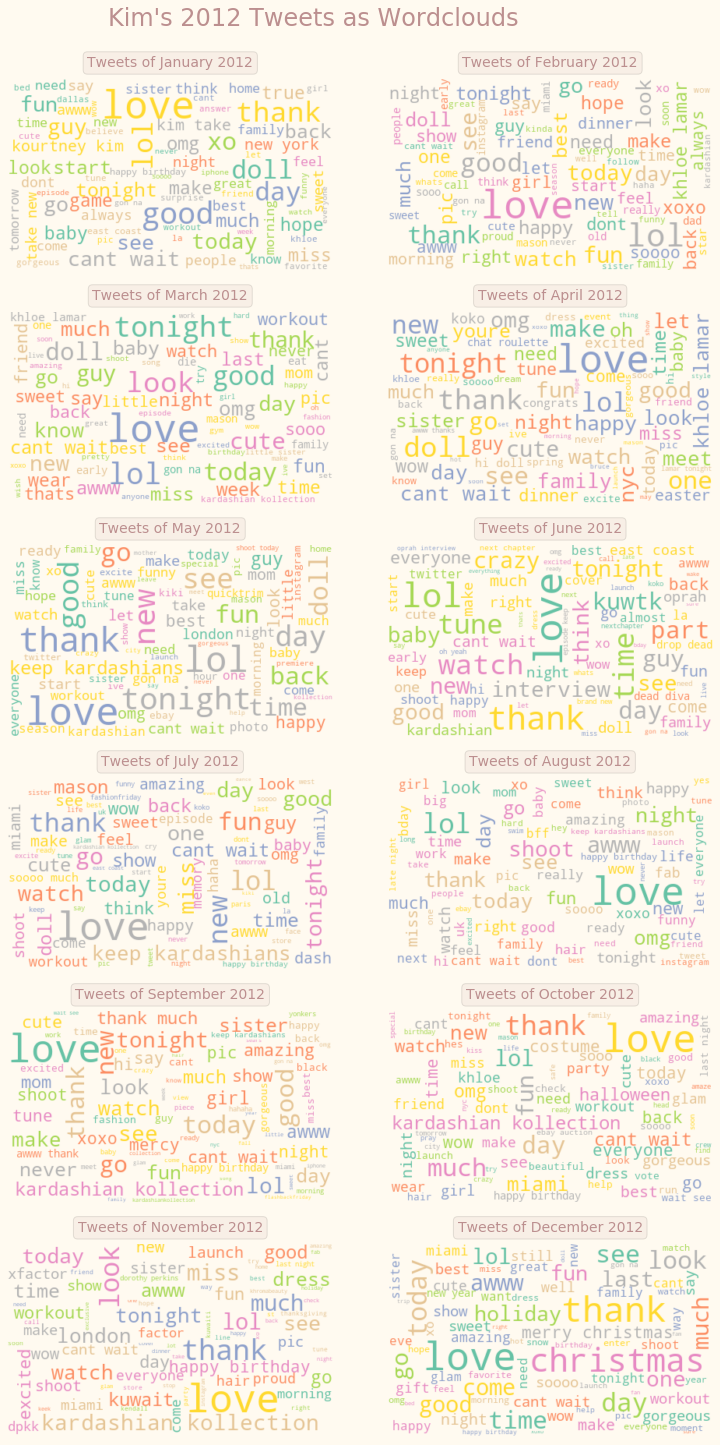

In [475]:
# Let's look at some 2012 clouds:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13,25))
fig.set_facecolor("floralwhite")
fig.suptitle("Kim's 2012 Tweets as Wordclouds", size=24, y=0.92, color="rosybrown")

# creating strings for clouds
cleaned_2012_month_strings = [join_mult_str_lists(month['lemmatized']) 
                              for month in clean_year_of_tweets]

# creating our clouds in a loop since it's easier and quicker than doing it one by one
index = 0
for x in range(6):
    for y in range(2):
        # cloudy = cloudify(strings_of_cleaned_2012_months[f"{month_names[index]}"])
        cloudy = cloudify(cleaned_2012_month_strings[index])
        ax = axes[x,y]
        ax.imshow(cloudy, interpolation='bilinear')
        ax.set_title(f'Tweets of {month_names[index]} 2012', 
                     fontsize=14, color="rosybrown", y=1.03,
                     bbox=dict(boxstyle="round", pad=0.3, 
                               fc="rosybrown", alpha=0.1, lw=1))
        ax.axis('off')
        index += 1
        
plt.subplots_adjust(left=0.15, 
                    bottom=None, 
                    right=0.95, 
                    top=None, 
                    wspace=0.03, 
                    hspace=None)

Kim sure loves a lot, is very thankful and loves to LOL on twitter. Let's look at the most used words of 2012:

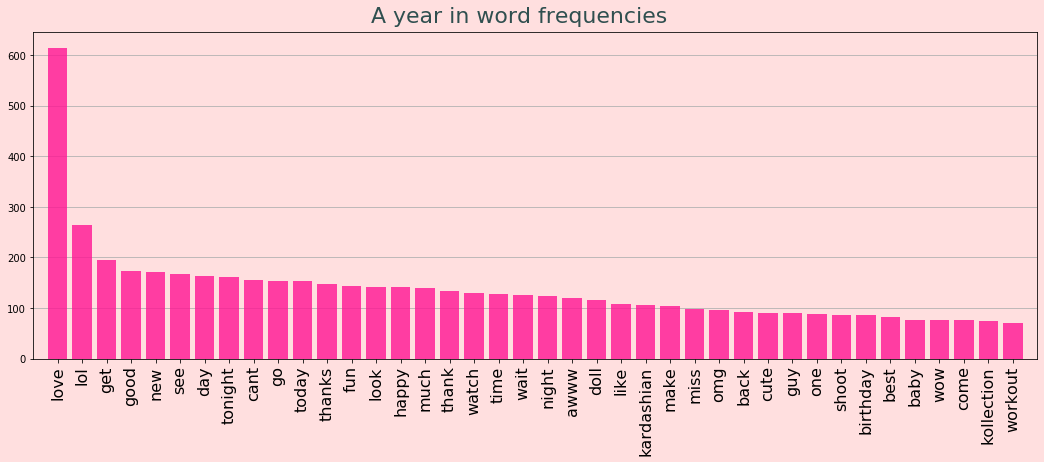

In [622]:
def word_counter(one_long_string, counter_limit):
    '''
    one_long_string: one long string that contains the words to be counted
    counter_limit: how many of the most common words counted should be returned
    returns: a list of the (counter_limit) most common words and a list containing
            the corresponding frequencies
    '''
    # separating all words into a list:
    very_long_word_list = re.split('\s+', one_long_string)
    # making all the words lower case:
    very_long_word_list = [word.lower() for word in very_long_word_list]
    # let's get to counting
    wordcounter = Counter(very_long_word_list)
    word_list = [item[0] for item in wordcounter.most_common(counter_limit)]
    word_frequencies = [item[1] for item in wordcounter.most_common(counter_limit)]
    
    return word_list, word_frequencies


# joining all 2012 tweets into one string:
string_of_2012 = " ".join(cleaned_2012_month_strings)
words_of_2012, word_frequency_2012 = word_counter(string_of_2012, 40)

fig = plt.figure(figsize=(18,6))
fig.suptitle("A year in word frequencies", fontsize=22, color='darkslategrey', y=0.94)
fig.set_facecolor("#ffdfdf")
ax1 = plt.subplot()
ax1.set_facecolor("#ffdfdf")
ax1.bar(words_of_2012, word_frequency_2012, color="deeppink", zorder=2, alpha=.8)
ax1.set_xlim(-1, 40)
ax1.grid(axis='y', zorder=1)
plt.xticks(rotation=90, size=16)
plt.show()

As we sort of already glimpsed from the word cloud earlier, Kim's most used words are all super positive: love, lol, good, thanks, fun, happy, thank, awww, cute...

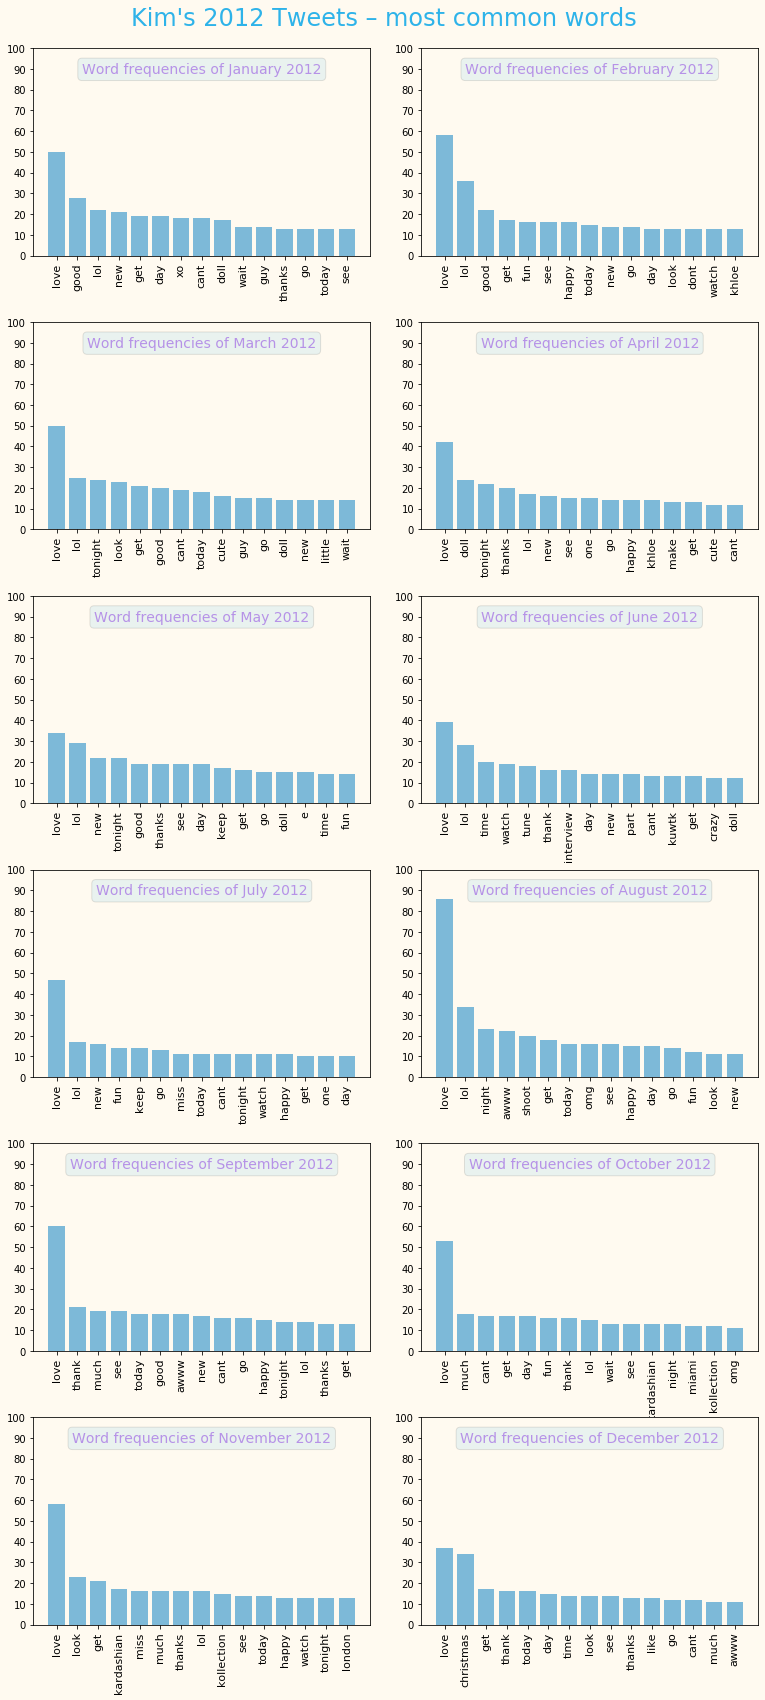

In [479]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(13,29))
fig.set_facecolor("floralwhite")
fig.suptitle("Kim's 2012 Tweets – most common words", y=0.9, size=24, color="#2EB3E9")

# creating our bars in a loop again

index = 0
for x in range(6):
    for y in range(2):
        words, frequencies = word_counter(cleaned_2012_month_strings[index], 15)
        ax = axes[x,y]
        ax.bar(words, frequencies, color="#7DB9D8")
        ax.set_title(f'Word frequencies of {month_names[index]} 2012', fontsize=14, 
                     color="#B692E7", y=.85, 
                     bbox=dict(boxstyle="round", pad=0.3, fc="#2EB3E9", alpha=0.1, lw=1))
        ax.set_xticklabels(words, rotation=90, size=11)
        ax.set_yticks(np.arange(0,101,10))
        ax.set_facecolor('floralwhite')
        index += 1

plt.subplots_adjust(hspace=0.32, wspace=0.15)

Kim loves <em><b>L.O.V.E.</b></em>! It is her most used word on twitter every single month. But do people love her back? Only in December does she love Christmas almost as much as love. Let's find out how many likes she earned for those love tweets in comparison to her... other tweets. 
Also note that this counter does not represent the number of tweets containing the word but the overall word count, meaning sometimes a word appears more than once in the same tweet.

We will dive into some love research right after we look at some popularity numbers:

# Kim's most popular Tweets
### Likes and Retweets

Let's take a closer look at the tweets that got the most likes and retweets and take a casual peek at her most favorited and most retweeted tweets of 2012 to get an idea what kind of content the people wanted to see from Kim.
Let's see how many likes and retweets she got over the course of the year:

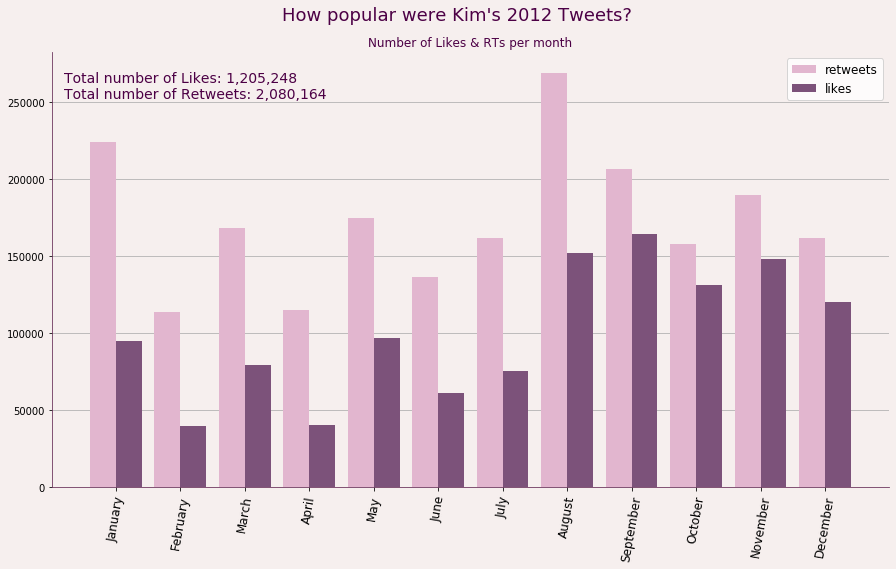

In [480]:
'''
chart showing number of likes and retweets every month
'''
# data
year_of_retweets = [sum(month['retweets']) for month in year_of_tweets]
total_retweets = sum(k2012['retweets'])
year_of_likes = [sum(month['favorites']) for month in year_of_tweets]
total_likes = sum(k2012['favorites'])

# colors and style settings
bg_color = "#F6EFEE"
bar_color = "#E2B6CF"
ax_color = "#682E58"
font_col = "#4c0045"
bar_width = 0.4
x = np.arange(len(month_names))  # x axis label/tick locations

# figure params
figx = plt.figure(figsize=(15,8))
figx.suptitle("How popular were Kim's 2012 Tweets?", size=18, y=.96, color=font_col)
figx.set_facecolor(bg_color)

# adding axis 
ax = figx.add_subplot(111)
ax.set_facecolor(bg_color)
ax.set_title("Number of Likes & RTs per month", color=font_col)
ax.grid(axis="y", zorder=1)

# bars showing monthly numbers of likes and retweets
ax.bar(x-0.5*bar_width, year_of_retweets, 
       width=bar_width, color=bar_color, label="retweets", zorder=2)

ax.bar(x+0.5*bar_width, year_of_likes, 
       width=bar_width, color="#7C527A", label="likes", zorder=2)

# setting x ticks
ax.set_xticks(x)
ax.set_xticklabels(month_names, rotation=80, size=12)

# setting the spine colors
ax.spines['bottom'].set_color(ax_color)
ax.spines['top'].set_color('none') 
ax.spines['right'].set_color('none')
ax.spines['left'].set_color(ax_color)

# text annotation
ax.text(-0.8, 253000, 
        f'Total number of Likes: {total_likes:,}\
        \nTotal number of Retweets: {total_retweets:,}', 
        fontsize=14, color=font_col)

ax.legend(fontsize='large')

plt.show()

So obviously there were stronger months and weaker months. But over all, her retweet numbers are always higher than her like numbers, sometimes appearing to be more than doubling those. In all, she received 800.000 more retweets than likes on her 2012 tweets to date. 

(It's important to note that the amount of tweets she sent each month is not taken into account here. So we obviously cannot conclude from this if the tweets in August were on average more popular than her tweets in any other month.)

Let's look at the top tweets in each of the two categories.

In [27]:
top_liked_tweets = k2012.sort_values(by=['favorites'], ascending=False)
top_liked_tweets.head(3)

,index,date,retweets,favorites,text,mentions,hashtags,permalink
2924,15901,2012-05-02 21:19:00-07:00,39119,45673,I can't wait for Call Of Duty Black Ops II to come out!!!! The graphics look crazy!,NaN,NaN,https://twitter.com/KimKardashian/status/197903221115715584
4016,16993,2012-01-29 09:51:00-08:00,45665,42348,I want to start a bible study group with my friends!,NaN,NaN,https://twitter.com/KimKardashian/status/163680586215600129
526,13503,2012-11-14 18:14:00-08:00,55313,33736,My favorite is Fifth Harmony!!!,NaN,NaN,https://twitter.com/KimKardashian/status/268899764609896448


## Kim's most liked tweets of 2012

Couple of <em>very</em> interesting things to note here:
<ul>
    <li>Kim's top tweet of 2012 is about COD Black Ops:<br/></li>
        
<img src="screenshots/Kim_cod_black_ops.png" width="400" alt="Kim' Black Ops Tweet" title="Kim's Black Ops Tweet" align="center"/>
<br/>
LOL. I can't. I literally can't. 
Apparently, Kim is a #gamergirl, because when asked about it, she replied:</ul>

>Nope! And no advertising-paid tweet either! I really love COD! RT @ROMANweMcQueen: lol i think ur accont was just hacked @KimKardashian	
<ul>
    <li>This is followed by a tweet about a bible study group she wants to start. I still can't: </li>
<img src="screenshots/Kim_bible_study.png" width="400" alt="Kim's bible study tweet" title="Kim's bible study tweet" align="center"/>
<br/>
    <li>Also up there: Kanye and how he is her fav rapper. No surprises there.</li>
    <li>Then she comes up with this genius dialogue:</li></ul>
<img src="screenshots/Kim_coffee_kids.png" width="400" alt="Kim's bible study tweet" title="Kim's bible study tweet" align="center"/>

That coffee tweet is disturbing, but interesting as it was clearly ahead of its time: North was born June 15th, 2013, so according to math, and also kind of according to the info in <a href="https://time.com/4591009/kim-kardashian-balmain-north-west/">this article</a> in Time Magazine, she was probably conceived a month-ish later. So yay, North, I guess?

<b>Most notably tho</b>, only 6 of her tweets have likes in the 5 digits. So there is a steep drop there. Let's look at her retweet numbers and then compare.

In [28]:
top_retweeted = k2012.sort_values(by=["retweets"], ascending=False)
top_retweeted.head(16)

,index,date,retweets,favorites,text,mentions,hashtags,permalink
526,13503,2012-11-14 18:14:00-08:00,55313,33736,My favorite is Fifth Harmony!!!,NaN,NaN,https://twitter.com/KimKardashian/status/268899764609896448
4016,16993,2012-01-29 09:51:00-08:00,45665,42348,I want to start a bible study group with my friends!,NaN,NaN,https://twitter.com/KimKardashian/status/163680586215600129
2924,15901,2012-05-02 21:19:00-07:00,39119,45673,I can't wait for Call Of Duty Black Ops II to come out!!!! The graphics look crazy!,NaN,NaN,https://twitter.com/KimKardashian/status/197903221115715584
3511,16488,2012-03-13 20:09:00-07:00,29026,21519,Anyone know exactly where rack city is?,NaN,NaN,https://twitter.com/KimKardashian/status/179766180926586880
4248,17225,2012-01-05 05:25:00-08:00,25008,7609,"Remember, people only rain on your parade because they're jealous of your sun & tired of their shade",NaN,NaN,https://twitter.com/KimKardashian/status/154916434575769600
1092,14069,2012-09-26 19:19:00-07:00,21586,17849,Mom- want any coffee? Me- yes please Mom- how do u take it? Me- half coffee half milk. Just make it the color of what my kid would be,NaN,NaN,https://twitter.com/KimKardashian/status/251143957453623296
2129,15106,2012-07-08 23:01:00-07:00,19818,4150,Welcome to the world Penelope Scotland Disick!!!! http://bit.ly/L37rMV,NaN,NaN,https://twitter.com/KimKardashian/status/222208925485891585
1233,14210,2012-09-14 15:10:00-07:00,16099,5645,I'm riiiii iiight here...I love this song!!!!,NaN,NaN,https://twitter.com/KimKardashian/status/246732790920527873
1878,14855,2012-08-03 13:25:00-07:00,14837,3131,"When you stop chasing the wrong things, you give the right things a chance to catch you.",NaN,NaN,https://twitter.com/KimKardashian/status/231485929511084032
837,13814,2012-10-17 08:50:00-07:00,14750,13595,But my favorite male rapper of all time is Kanye ;-),NaN,NaN,https://twitter.com/KimKardashian/status/258595819790422016


## Top retweeted Kim tweets of 2012

Now, we can see that among her top retweeted tweets, firstly, there is a lot of overlap with her top favorited tweets, with the bibly study tweet scoring 2nd place again. Plus there are <em>a lot</em> of boring inspirational quotes in there like 
<ul>
    <li>Remember, people only rain on your parade because they're jealous of your sun & tired of their shade.
    </li>
    <li>When you stop chasing the wrong things, you give the right things a chance to catch you.
    </li>
    <li>It's not that people don't know what they got until it's gone; they just didn't think they'd lose it.
    </li>
    <li>Sometimes the person you fall for isn't ready to catch you.
    </li>
    <li>the grass is greener where you water it....not on the other side
    </li>
    </ul>
All of these have over 10.000 retweets. I mean, sure, lots of people are into this type of "inspirational" content and are probably retweeting it to share it with their followers. These types of quotes are also retweetable because they are sort of universal, as in not tied to Kim as a person, so even those who are not her fans per se might throw in a retweet for the "uplifting" message.

<b>It's also worth noting</b> that some of these old tweets are being repopularized after a while and gain interaction months, even several years after they were originally crafted by Kimberly herself. This is very obvious when taking a look at the replies to any of the more ridiculous-seeming tweets from back then. The bible study group tweet for instance is garnering a lot of replies even to this day. So it's safe to say that some of the retweets and likes are still coming in today.

Let's compare like and retweet behaviour. We alreade know she got more retweets and likes. But do tweets with more likes also get more retweets and vice versa? Let's try to find out.

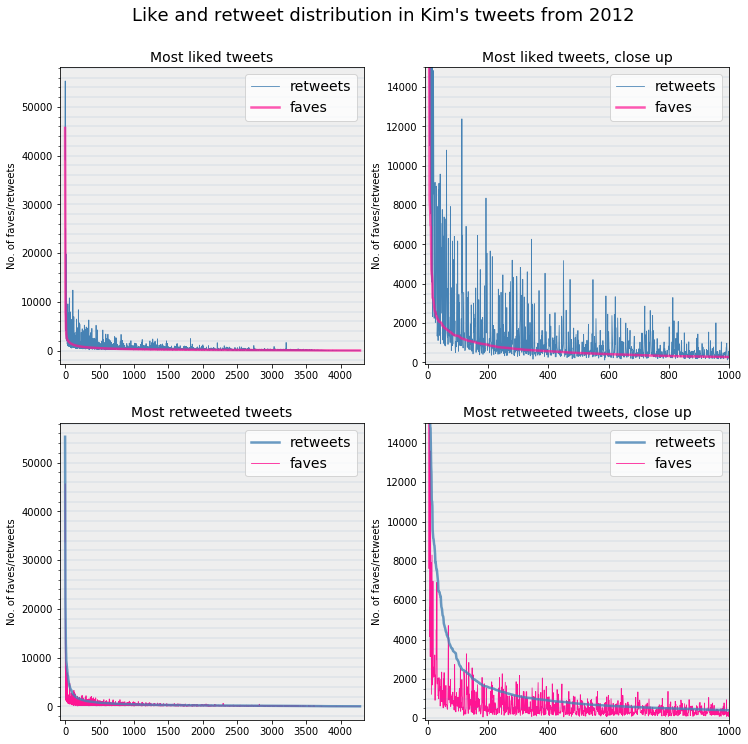

In [29]:
figure = plt.figure(figsize=(12,12))
figure.suptitle("Like and retweet distribution in Kim's tweets from 2012", size=18, y=.95)

# setting limits for smaller close-up plots
x_limit = 1000
y_limit = 15000

# first plot: retweet distribution among most liked tweets
ax = figure.add_subplot(221)
ax.set_xlim(-80, 4340)
ax.set_title("Most liked tweets", fontsize=14)
rts = ax.plot(np.arange(len(top_liked_tweets)), top_liked_tweets.retweets, 
              color="steelblue", label="retweets", linewidth=.8)
favs = ax.plot(np.arange(len(top_liked_tweets)), top_liked_tweets.favorites, 
               color="deeppink", label="faves", linewidth=2.5, alpha=.7)

# 2nd plot: close-up of retweet distribution among most liked tweets
ax2 = figure.add_subplot(222)
ax2.set_title("Most liked tweets, close up", fontsize=14)
ax2.set_xlim(-10, x_limit)
ax2.set_ylim(-80, y_limit)
rts = ax2.plot(np.arange(len(top_liked_tweets)), top_liked_tweets.retweets, 
              color="steelblue", label="retweets", linewidth=.8)
favs = ax2.plot(np.arange(len(top_liked_tweets)), top_liked_tweets.favorites, 
               color="deeppink", label="faves", linewidth=2.5, alpha=.7)

# 3rd plot: like distribution among most retweeted tweets
ax3 = figure.add_subplot(223)
ax3.set_title("Most retweeted tweets", fontsize=14)
ax3.set_xlim(-80, 4340)
rts = ax3.plot(np.arange(len(top_retweeted)), top_retweeted.retweets, zorder=2,
              color="steelblue", label="retweets", linewidth=2.5, alpha=.8)
favs = ax3.plot(np.arange(len(top_retweeted)), top_retweeted.favorites, zorder=1,
               color="deeppink", label="faves", linewidth=.8)

# 4th plot: close up of like distribution among most retweeted tweets
ax4 = figure.add_subplot(224)
ax4.set_title("Most retweeted tweets, close up", fontsize=14)
ax4.set_xlim(-10, x_limit)
ax4.set_ylim(-80, y_limit)
rts = ax4.plot(np.arange(len(top_retweeted)), top_retweeted.retweets, zorder=2,
              color="steelblue", label="retweets", linewidth=2.5, alpha=.8)
favs = ax4.plot(np.arange(len(top_retweeted)), top_retweeted.favorites, zorder=1,
               color="deeppink", label="faves", linewidth=.8)

# style settings for all axes in the figure
for axis in figure.axes:
    axis.set_facecolor("#EEEEEE")
    axis.set_ylabel("No. of faves/retweets")
    axis.yaxis.set_minor_locator(AutoMinorLocator())
    axis.legend(fontsize=14)
    axis.grid(axis="y", which="both", color='steelblue', linestyle='-', linewidth=0.15)

plt.show()

As was sort of expected when looking at the top of the most-faved and most-retweeted lists, there are a couple of high performers among her tweets, raking in 40,000+ likes or retweets and then there is a steep curve going down very quickly. 

We could probably do a quick histogram of her like and retweet numbers.

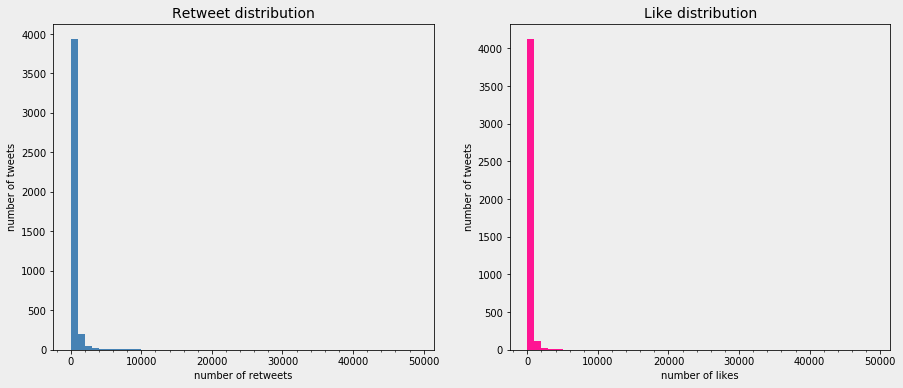

In [623]:
bins = np.arange(0,50000,1000) # increasing by 1000 each bin

figO = plt.figure(figsize=(15,6))
figO.set_facecolor("#EEEEEE")

ax1 = figO.add_subplot(121)
ax1.set_facecolor("#EEEEEE")
ax1.set_title("Retweet distribution", fontsize=14)
ax1.set_xlabel("number of retweets")
ax1.set_ylabel("number of tweets")
ax1.hist(k2012.retweets, bins=bins, color="steelblue")
ax1.xaxis.set_minor_locator(AutoMinorLocator())

ax2 = figO.add_subplot(122)
ax2.set_facecolor("#EEEEEE")
ax2.set_title("Like distribution", fontsize=14)
ax2.set_xlabel("number of likes")
ax2.set_ylabel("number of tweets")
ax2.hist(k2012.favorites, bins=bins, color="deeppink")
ax2.xaxis.set_minor_locator(AutoMinorLocator())

plt.show()

The overwhelming majority of her tweets has 1000 or less retweets or likes.

Now, let's go back to those monthly numbers and take into account the number of tweets and average amount of likes and retweets received for each tweet.

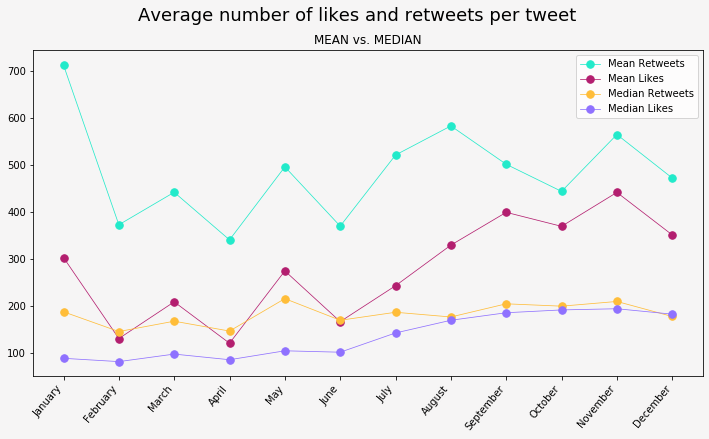

In [31]:
# data
mean_retweet_numbers = [np.mean(month['retweets']) for month in year_of_tweets]
mean_like_numbers = [np.mean(month['favorites']) for month in year_of_tweets]
median_retweet_numbers = [np.median(month['retweets']) for month in year_of_tweets]
median_like_numbers = [np.median(month['favorites']) for month in year_of_tweets]

# color and style settings
bckgrnd_clr = "#f6f5f5"
first, second, third, fourth = ["#22eaca", "#b31e6f", "#ffbd39", "#8f71ff"]
linestyle = dict(linewidth=0.75, marker=".", ms=15)

# figure params
figg = plt.figure(figsize=(12,6))
figg.suptitle("Average number of likes and retweets per tweet", size=18)
figg.set_facecolor(bckgrnd_clr)

# adding axis
ax = figg.add_subplot(111)
ax.set_title("MEAN vs. MEDIAN")
ax.set_facecolor(bckgrnd_clr)

# adding plots
ax.plot(month_names, mean_retweet_numbers, color=first, 
        label="Mean Retweets", **linestyle)

ax.plot(month_names, mean_like_numbers, color=second, 
        label="Mean Likes", **linestyle)

ax.plot(month_names, median_retweet_numbers, color=third, 
        label="Median Retweets", **linestyle)

ax.plot(month_names, median_like_numbers, color=fourth, 
        label="Median Likes", **linestyle)

plt.xticks(rotation=50, ha='right')

ax.legend()

plt.show()

So again, this goes to show that almost every month, especially then it comes to retweets, there are a couple of very well performing tweets that drive up the arithmetic mean. The median numbers for both retweets and likes are much lower.

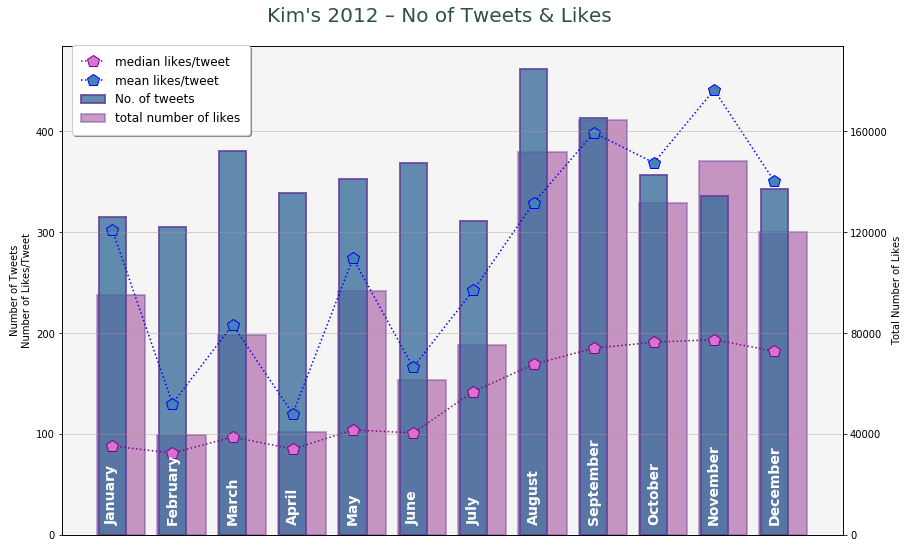

In [627]:
'''
bar chart showing total numnber of likes/tweets 
+ mean and median like numbers for each month
'''

# data
monthly_values = list(map(len, year_of_tweets))
monthly_fav_values = [0.0025 * sum(year_of_tweets[x]['favorites']) for x in range(12)]
average_faves_per_tweet = (np.array(monthly_fav_values)/0.0025) / np.array(monthly_values)

# figure and axis params
fig = plt.figure(figsize=(14,9))
fig.suptitle("Kim's 2012 – No of Tweets & Likes", 
             fontsize=20, color='darkslategrey', y=0.94)
ax = fig.add_subplot(111)
ax.set_xticks([])

# bars for monthly tweet amounts
ax.bar(month_names, monthly_values, color='#3c6f9c', ec="#5F3D97",
       width=.45, zorder=2, linewidth=2, linestyle="-", alpha=.8, label="No. of tweets")
ax.set_ylabel("Number of Tweets\nNumber of Likes/Tweet")
ax.set_facecolor("whitesmoke")

# adding year labels on bars instead of using x-ticks
bars = ax.patches
for ind, bar in enumerate(bars):
    xloc = month_names[ind]
    yloc = 10
    ax.text(xloc, yloc, str(xloc), color="w", size=14, 
            fontweight="demibold", rotation=90, ha="center", va="bottom")
    
# background bars showing number of likes received that months
ax.bar(np.arange(12)+.15, monthly_fav_values, color="#7F0475", 
        width=.8, zorder=1, linewidth=2, ec="#5F3D97",
        linestyle="-", alpha=.4, label="total number of likes")

# line plot of average number of likes per tweet that month
ax.plot(median_like_numbers, color="purple", linestyle="dotted",
       marker="p", markerfacecolor="orchid", markersize="13", label="median likes/tweet")

ax.plot(mean_like_numbers, color="blue", linestyle="dotted",
       marker="p", markerfacecolor="steelblue", markersize="13", label="mean likes/tweet")

# clone x axis and set y axis to fav values
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Total Number of Likes')
ax2.set_yticklabels(list(int(x/0.0025) for x in ax.get_yticks()))

plt.grid(axis="y", color="rosybrown", alpha=.4, zorder=1, linewidth=1)

fig.legend(loc='upper left', fontsize=12, 
           bbox_to_anchor=(0.065, 0.785), 
           borderpad=.8, shadow=True)

plt.show()

In [33]:
# data for love chart

number_of_love_tweets = []
mean_likes_love_tweets = []
median_likes_love_tweets = []
mean_retweets_love_tweets = []
median_retweets_love_tweets = []

number_of_nolove_tweets = []
mean_likes_nolove_tweets = []
median_likes_nolove_tweets = []
mean_retweets_nolove_tweets = []
median_retweets_nolove_tweets = []

for month in clean_year_of_tweets:
    # calculating the mean and median rts and likes of love tweets
    love_tweets = month[month['cleaned'].str.contains('love') == True]
    number_of_love_tweets.append(len(love_tweets))
    mean_likes_love_tweets.append(np.mean(love_tweets['favorites']))
    median_likes_love_tweets.append(np.median(love_tweets['favorites']))
    mean_retweets_love_tweets.append(np.mean(love_tweets['retweets']))
    median_retweets_love_tweets.append(np.median(love_tweets['retweets']))
    
    non_love_tweets = month[month['cleaned'].str.contains('love') == False]
    number_of_nolove_tweets.append(len(non_love_tweets))
    mean_likes_nolove_tweets.append(np.mean(non_love_tweets['favorites']))
    median_likes_nolove_tweets.append(np.median(non_love_tweets['favorites']))
    mean_retweets_nolove_tweets.append(np.mean(non_love_tweets['retweets']))
    median_retweets_nolove_tweets.append(np.median(non_love_tweets['retweets']))

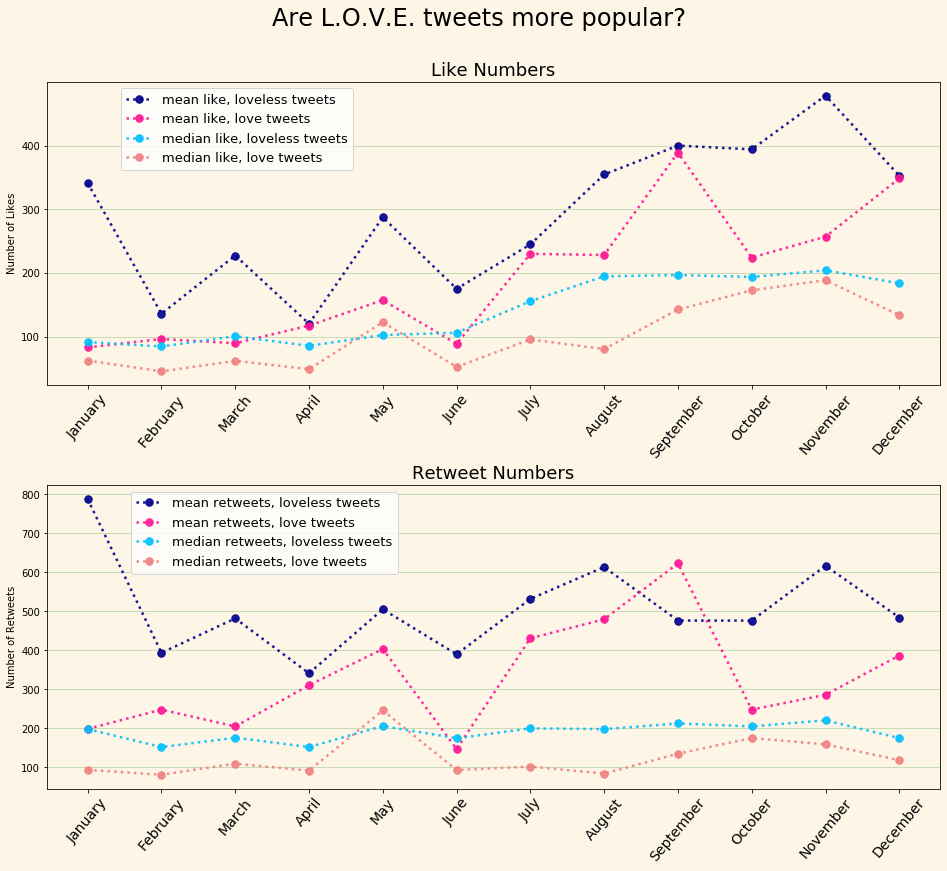

In [176]:
bg_c = "oldlace"
index = np.arange(len(month_names))
bar_width = 0.2
opacity = 0.9
barcolors = ['darkblue', 'deeppink', 'deepskyblue', 'lightcoral']
linestyle = dict(linewidth=2.5, linestyle=':', marker='.', markersize=15) 
titlestyle = dict(fontsize=18)

fig1 = plt.figure(figsize=(16, 13))
fig1.suptitle('Are L.O.V.E. tweets more popular?', size=24, y=0.96)
fig1.set_facecolor(bg_c)

ax1 = fig1.add_subplot(211)
ax1.set_title("Like Numbers", **titlestyle)
ax1.set_ylabel('Number of Likes')

ax1.plot(index, mean_likes_nolove_tweets, alpha=opacity, zorder=2,
        color=barcolors[0], label='mean like, loveless tweets', **linestyle)

ax1.plot(index, mean_likes_love_tweets, alpha=opacity, zorder=2,
         color=barcolors[1], label='mean like, love tweets', **linestyle)

ax1.plot(index, median_likes_nolove_tweets, alpha=opacity, zorder=2,
        color=barcolors[2], label='median like, loveless tweets', **linestyle)

ax1.plot(index, median_likes_love_tweets, alpha=opacity, zorder=2,
        color=barcolors[3], label='median like, love tweets', **linestyle)

ax1.legend(fontsize=13, bbox_to_anchor=(0.35, 1))


ax2 = fig1.add_subplot(212)
ax2.set_title("Retweet Numbers", **titlestyle)
ax2.set_ylabel('Number of Retweets')

ax2.plot(index, mean_retweets_nolove_tweets, alpha=opacity, zorder=2,
        color=barcolors[0], label='mean retweets, loveless tweets', **linestyle)

ax2.plot(index, mean_retweets_love_tweets, alpha=opacity, zorder=2,
         color=barcolors[1], label='mean retweets, love tweets', **linestyle)

ax2.plot(index, median_retweets_nolove_tweets, alpha=opacity, zorder=2,
        color=barcolors[2], label='median retweets, loveless tweets', **linestyle)

ax2.plot(index, median_retweets_love_tweets, alpha=opacity, zorder=2,
        color=barcolors[3], label='median retweets, love tweets', **linestyle)

ax2.legend(fontsize=13, bbox_to_anchor=(0.4, 1))

# style settings for all axes
for ax in fig1.axes:
    ax.set_facecolor(bg_c)
    ax.grid(axis="y", c="forestgreen", zorder=2, alpha=.3)
    ax.set_xticks(index)
    ax.set_xticklabels(month_names, rotation=50, size=14)

plt.subplots_adjust(hspace=0.33)

plt.show()

### Are your L.O.V.E. tweets more popular, Kim? 
#### No.

Here we are observing the mean and median like and retweet numbers each month in 2012 for <b>tweets containing the word love</b> and <b>tweets not containing the word love</b>. As we can see, the mean as well as the medium like numbers for loveless tweets are generally higher. 

Only in April, September, and December are means almost identical with the love tweets still falling slightly below the no-love tweets. Only in May is the median for the love tweets slightly above the median for the no-love tweets. So I guess there is not much love for Kim's love tweets?

Similarly, the retweet numbers are higher for non-love tweets than for love tweets. Possibly because a lot of her love tweets are (personalized) replies ("Love you doll!!!") that are not as interesting for the general public. 

In September, there must have been a very highly retweeted love tweet – let's find it! 

In [489]:
print(f"The median retweet in September was {median_retweets_love_tweets[8]}")
print(f"The mean retweet in September was {mean_retweets_love_tweets[8]}")

The median retweet in September was 135.0
The mean retweet in September was 623.0350877192982


Let's find these top retweeted love tweets that boosted her like and RT numbers in September of 2012!

In [499]:
# filter out tweets containing love, sort df by retweets and drop cols we don't need
clean_sep12[clean_sep12['cleaned'].str.contains('love')].sort_values(
    by="retweets", ascending=False).head(4).drop(
    columns=['index','hashtags', 'mentions','cleaned','lemmatized'])

,date,retweets,favorites,text,permalink
1200,2012-09-14 15:10:00-07:00,16099,5645,I'm riiiii iiight here...I love this song!!!!,https://twitter.com/KimKardashian/status/246732790920527873
1053,2012-09-27 05:53:00-07:00,4395,1668,Happy 3 year Anniversary @KhloeKardashian & @RealLamarOdom! I love you guys!!!,https://twitter.com/KimKardashian/status/251303526570000385
1010,2012-09-30 18:44:00-07:00,2331,3276,I love you dad and I've missed you so much! Wish today never happened 9 years ago but I know your in a better place. See you in heaven,https://twitter.com/KimKardashian/status/252584799502479360
1111,2012-09-23 23:21:00-07:00,1906,1343,Can't sleep. Up watching this Katy Perry movie. OMG this movie made me fall in love with her even more! Such a good movie!,https://twitter.com/KimKardashian/status/250117677996191744


Ok so her top retweeted tweets were:
<ul>
    <li>a) Kim raving about a song, I believe she is referring to <a href="https://www.youtube.com/watch?v=v5UvS_Lc5Aw">this track</a> by Justin Bieber and Drake. </li><li>
    b) Kim wishing Khloe and Lamar a happy anniversary.
    </li><li>
    c) Kim tweeting about her father on the 9th anniversary of his death.</li>
    <li>
        d) Kim raving about a Katy Perry movie.</li>
    </ul>
That was not all that exciting. We had hoped for more exciting content. Bur even Kimberly cannot deliver top tweets every day of every month. 

Let's look at some tweet times to see whether she has a preferred time of day for tweeting out her love.

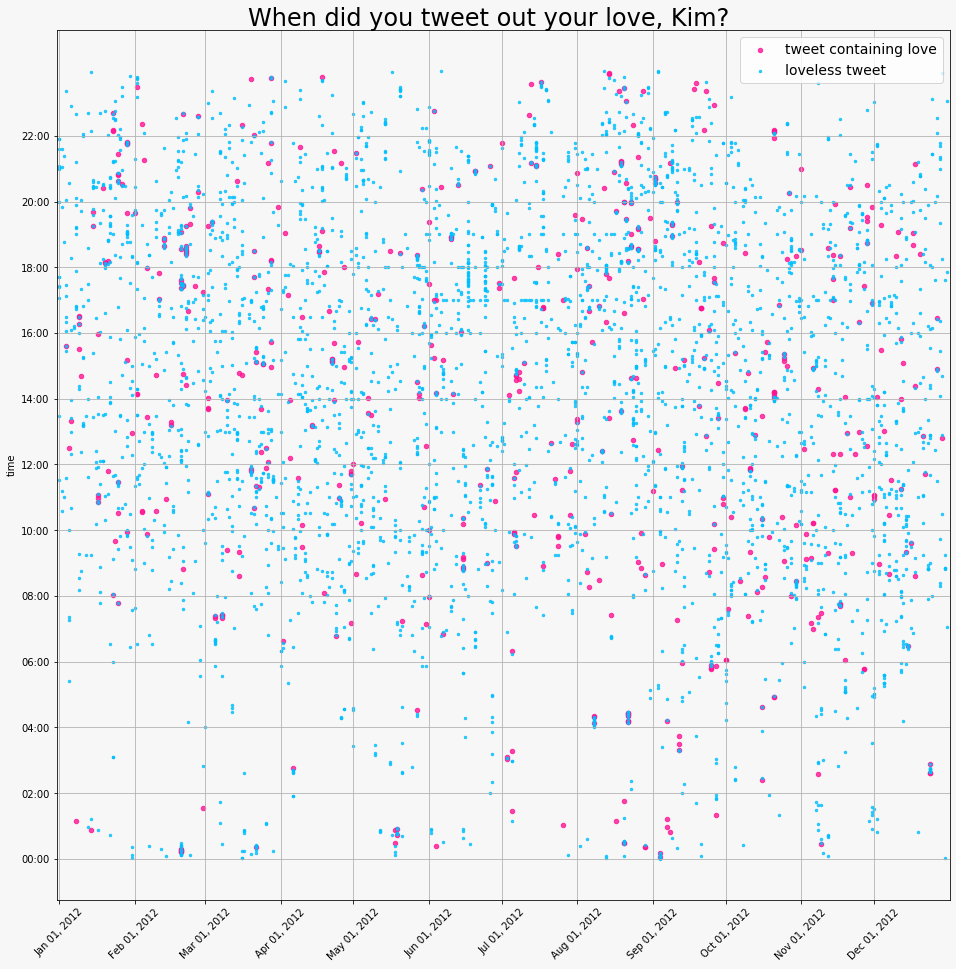

In [502]:
'''
When did Kim tweet about love in 2012?
'''

# style settings
title = "When did you tweet out your love, Kim?"
bg_color = "#f7f7f7"
love_col, no_love_col = ['deeppink', 'deepskyblue']
opacity = 0.8

# figure params
fig = plt.figure(figsize=(16,16))
fig.suptitle(title, size=24, y=0.9)
fig.set_facecolor(bg_color)

# setting up axis
ax = fig.add_subplot(111)
ax.set_facecolor(bg_color)
ax.grid(axis='both', zorder=1, which='both')
ax.set_xlim([datetime.date(2011, 12, 31), datetime.date(2013, 1, 1)])
    
# data for love scatter
love_2012 = clean2012[clean2012['cleaned'].str.contains('love')]
love_days = love_2012['date'].dt.date
all_times = love_2012['date'].dt.strftime('%H:%M') # turn dt obj into str
love_times = [datetime.datetime.strptime(t, '%H:%M').time() 
              for t in all_times] # turn str into time obj

# data for no love scatter
no_love_2012 = clean2012[clean2012['cleaned'].str.contains('love') == False]
no_love_days = no_love_2012['date'].dt.date
all_times = no_love_2012['date'].dt.strftime('%H:%M') # turn dt obj into str
no_love_times = [datetime.datetime.strptime(t, '%H:%M').time() 
                 for t in all_times] # turn str into time obj

# scatter plots – for love tweets and no love tweets 
love_scatter = ax.scatter(x_days, y_times, 
                          c=love_col, alpha=opacity,
                          label="tweet containing love", s=20)  

no_love_scatter = ax.scatter(x1_days, y1_times, 
                             c=no_love_col, alpha=opacity,
                             label="loveless tweet", s=6) 

# setting ticks and ticklabels for x and y axis
xticks = [datetime.date(2012, i, 1) for i in range(1,13)] # set ticks to 1st of each month
ax.set_xticks(xticks)
y_tick_times = [f"{a:02d}:00:00" for a in range(24) if a%2==0] # list of times for y axis
ax.set_yticks(y_tick_times)
ax.set_xticklabels(xticks, rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))

ax.legend(loc="upper right", fontsize=14)

plt.show()

There does not seem to be a clear pattern here. 
What jumps right into our eyes is those two days in June where she must've been firing out tweets by the dozen within a two(ish) hour window... I wonder what that's about.
But let's not get distracted and see what kinds of things and people Kim loved so much in 2012 that she had to tell everyone about them...

In [503]:
# calculating the types of love Kim liked to spread on twitter:
love_you = love_2012['cleaned'].str.contains('love you')
love_this = love_2012['cleaned'].str.contains('love this')
love_u = love_2012['cleaned'].str.contains('love u')
love_it = love_2012['cleaned'].str.contains('love it')
love_a = love_2012['cleaned'].str.contains('love a')
loved_loves = ((love_2012['cleaned'].str.contains('loved')) 
               | (love_2012['cleaned'].str.contains('loves')))
love_my = love_2012['cleaned'].str.contains('love my')
love_to_when = ((love_2012['cleaned'].str.contains('love to'))
                 | (love_2012['cleaned'].str.contains('love when')))
rest = ((love_you==False) & (love_this==False) & (love_u==False) & 
                    (love_it==False) & (love_a==False) & (loved_loves==False) & 
                    (love_my==False) & (love_to_when==False))

love_bars = np.sum([love_you, love_u, love_this,  
                    love_it, love_a, loved_loves, 
                    love_my, love_to_when, rest], axis=1)

love_bar_percentages = love_bars/len(love_2012)
# this might be more than 100% total because some tweets contain more than one type of love

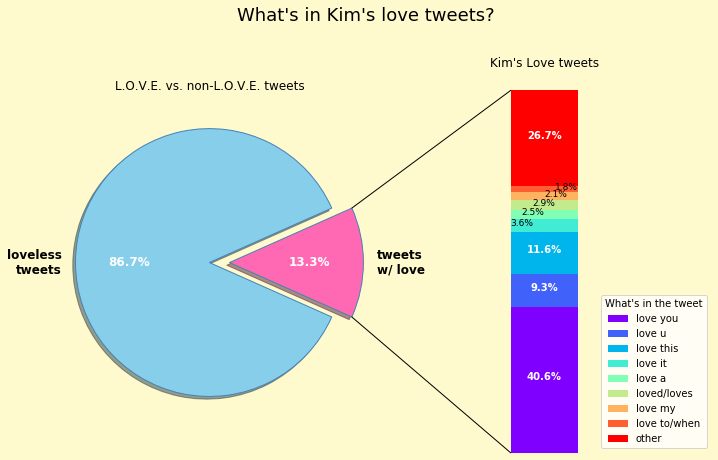

In [508]:
# make figure and assign axis objects
fig = plt.figure(figsize=(12, 7))
fig.suptitle("What's in Kim's love tweets?", fontsize=18, y=1.01)
fig.set_facecolor("lemonchiffon")
ax1 = fig.add_subplot(121)
ax1.set_title("L.O.V.E. vs. non-L.O.V.E. tweets")
ax2 = fig.add_subplot(122)
ax2.set_title("Kim's Love tweets")
fig.subplots_adjust(wspace=0)

# pie chart parameters
lovepie_vals = [len(love_2012), len(no_love_2012)]
lovepie_labels = ['tweets\nw/ love', 'loveless\ntweets']
explode = [0.15, 0]
wedgeprops = {'linewidth': 1, 'edgecolor': 'steelblue'}
textprops = {'color':"w", 'size': 12, 'weight':'bold'}

# rotating start anglw so that first wedge is split by x-axis
perc_love = len(love_2012)/len(clean2012)
angle = -180 * (perc_love)

# bar chart parameters
xpos = 0
bottom = 0
ratios = love_bar_percentages
width = .3
colors = plt.cm.rainbow(np.linspace(0, 1, len(ratios)))
labels = ['love you', 'love u', 'love this',  
                    'love it', 'love a', 'loved/loves', 
                    'love my', 'love to/when', 'other']

# pie 
wedges, texts, autotexts = ax1.pie(lovepie_vals,  labels=lovepie_labels, 
                                   startangle=angle, autopct='%.1f%%', 
                                   shadow=True, explode=explode,
                                   colors=['hotpink', 'skyblue'], 
                                   textprops=textprops, 
                                   wedgeprops=wedgeprops)

plt.setp(texts, color="k")

# bar – built in a loop, stacking patches on top of each other
extra = -0.1
for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    if (ax2.patches[j].get_height() * 100) > 7:
        # if patch is high enough, the label will be centered
        ax2.text(xpos, ypos, "%.1f%%" % (ax2.patches[j].get_height() * 100),
                 ha='center', color='w', weight='bold')
    else:
        # since our tiny stacks are a little cluttered
        # we're moving each label a little to the right for better readability
        ax2.text(xpos+extra, ypos, "%.1f%%" % (ax2.patches[j].get_height() * 100),
                 ha='center', color='k', size=9)
        extra+=0.05
        
# adding legend
ax2.legend(title="What's in the tweet", labels=labels, loc='lower right')
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(- width / 2, bar_height), xyB=(x, y),
                      coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(- width / 2, 0), xyB=(x, y), coordsA="data",
                      coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

plt.show()

Interestingly, almost 50 percent of her love tweets contain the phrase <em>love you</em> or <em>love u</em> (1 tweet contains both!). So that is definitely a big part of what her love on twitter is about.
<em>love this</em> is also kind of important which most of the time is her talking about a product ('I love this dress' etc.). The other types are not very common and a good quarter remains <em>other</em> because there doesn't seem to be another common love denominator among them. 


### construction site
##### pls do not enter below this cell


In [576]:
def join_lemmatized_lists(list_of_tweet_lists):
    '''
    joins multiple lists of lemmatized tweets together into a list
    where each word is its own item
    '''
    x = list(list_of_tweet_lists)
    long_string = " ".join(word for a_list in x for word in a_list)
    very_long_word_list = re.split('\s+', long_string)
    
    return very_long_word_list

In [580]:
janny_12 = join_lemmatized_lists(clean_jan12['lemmatized'])

wordcounter = Counter(janny_12)
word_list = [item[0] for item in wordcounter.most_common()]
word_frequencies = [item[1] for item in wordcounter.most_common()]

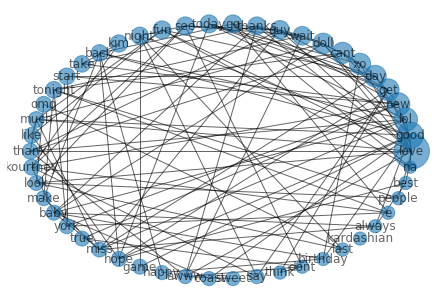

In [579]:
KKW = nx.Graph()

limit = 50

for word, freq in wordcounter.most_common(limit):
    KKW.add_node(word)

word_list = [item[0] for item in wordcounter.most_common(limit)]

edges = []
for tweet in clean_jan12['lemmatized']:
    try:
        for index in range(len(tweet)):
            if tweet[index] in word_list and tweet[index+1] in word_list:
                edge = (tweet[index], tweet[index+1])
                if not edge in edges:
                    edges.append(edge) 
    except IndexError:
        pass
            
KKW.add_edges_from(edges)
nx.draw_circular(KKW, alpha=0.6, 
        node_size=[v*25 for v in word_frequencies], with_labels=True)

In [ ]:
G.add_nodes_from([2, 3])
G

In [ ]:
H = nx.path_graph(10)
G.add_nodes_from(H)

In [ ]:
G

In [ ]:
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw_circular(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [ ]:
years = np.array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])
tweet_years = [clean2009, clean2010, clean2011, clean2012, clean2013, 
           clean2014, clean2015, clean2016, clean2017, clean2018, clean2019]

# let us join all those tweets together into giant strings almost 
# as long as Kylie's bank statement
cloud_str_dict = {}
for index in range(len(tweet_years)):
    key = f"cloud{years[index]}"
    x = tweet_years[index]["lemmatized"].tolist() 
    cloud_str_dict[key] = " ".join(word for li in x for word in li)  

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,25))
fig.set_facecolor("floralwhite")
fig.suptitle("Kim's Tweets as Wordclouds", size=24, y=0.92, color="rosybrown")

index = 0
for x in range(5):
    for y in range(2):
        cloudy = cloudify(cloud_str_dict[f"cloud{years[index]}"])
        ax = axes[x,y]
        ax.imshow(cloudy, interpolation='bilinear')
        ax.set_title(f'Tweets of {years[index]}', fontsize=14, color="rosybrown", y=1.03,
                     bbox=dict(boxstyle="round", pad=0.3, fc="rosybrown", alpha=0.1, lw=1))
        ax.axis('off')
        index+=1

In [ ]:
'''
Let's take a closer look at when Kim likes to tweet in 2012
'''
title = "Kim's 2012 - When did she tweet?"
bg_color = "#f7f7f7"
linecolor = "#078298"
fig = plt.figure(figsize=(20,36))
fig.suptitle(title, size=24, y=0.91)

# adding our axes
ax0 = plt.subplot2grid((8, 2), (0, 0), colspan=2, rowspan=2) # big chart on top
ax1 = plt.subplot2grid((8, 2), (2, 0)) # jan           
ax2 = plt.subplot2grid((8, 2), (2, 1)) # feb         
ax3 = plt.subplot2grid((8, 2), (3, 0)) # mar          
ax4 = plt.subplot2grid((8, 2), (3, 1))
ax5 = plt.subplot2grid((8, 2), (4, 0))
ax6 = plt.subplot2grid((8, 2), (4, 1))           
ax7 = plt.subplot2grid((8, 2), (5, 0))  
ax8 = plt.subplot2grid((8, 2), (5, 1))   
ax9 = plt.subplot2grid((8, 2), (6, 0))            
ax10 = plt.subplot2grid((8, 2), (6, 1)) 
ax11 = plt.subplot2grid((8, 2), (7, 0))            
ax12 = plt.subplot2grid((8, 2), (7, 1)) 

for ax in fig.axes:
    ax.set_facecolor(bg_color)
    

# data for scatter
x_days = k2012['date'].sort_values().dt.date
alltimes = k2012['date'].sort_values().dt.strftime('%H:%M')
y_times = [datetime.datetime.strptime(t, '%H:%M').time() for t in alltimes]
# data for colorbar gradient - figuring out timedelta between tweet and next tweet
timeit = k2012['date'].sort_values().tolist()
minutes = []
for index, time in enumerate(timeit):
    next_index = (index + 1) % len(k2012)
    # when last date in 2012 is reached, first date of 2013 is used to create the delta
    if next_index == 0:
        delta = k2013["date"].sort_values().tolist()[0] - time
    # looking at next time and creating a delta (= how long until the next tweet)
    else:  
        delta = timeit[next_index] - time     
    m = delta.seconds / 60
    minutes.append(int(m))

# settings for colorbar
max_value = max(minutes)
min_value = min(minutes)
ax4_cmap = plt.get_cmap('RdPu_r')
norm = matplotlib.colors.Normalize(vmin=min_value,vmax=max_value)
sm = plt.cm.ScalarMappable(cmap=ax4_cmap, norm=norm)
sm.set_array([])
# adding the colorbar: 
cbar = fig.colorbar(sm, ax=ax0, label="Minutes until next tweet", fraction=0.1, pad=0.01)

# chart
scatter = ax0.scatter(x_days, y_times, s=1, c=minutes, cmap="RdPu_r")
ax0.set_facecolor(bg_color)
ax0.set_xlim([datetime.date(2011, 12, 31), datetime.date(2013, 1, 1)])
firsts = [datetime.date(2012, i, 1) for i in range(1,13)]
ax0.set_xticks(firsts)
y_tick_times = [f"{a:02d}:00:00" for a in range(24) if a%2==0] # list of times for y axis
ax0.set_yticks(y_tick_times)
ax0.set_xticklabels(firsts, rotation=45)
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax0.grid(axis='both', zorder=1, which='both')

In [ ]:
# let's look at what a cryface kimoji shaped wordcloud would look like

# putting all tweets into one single string
onestring = " ".join(cloud_str_dict.values())
all_tweet_word_list = re.split('\s+', onestring)
all_tweet_word_list = [w.lower() for w in all_tweet_word_list]
co = Counter(all_tweet_word_list)

# Generate a word cloud image
mask = np.array(Image.open("screenshots/kimoji.png"))
wordcloud_kimoji = WordCloud(background_color="white", mode="RGBA", 
                             max_words=2000, mask=mask).generate_from_frequencies(co)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_kimoji.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

In [ ]:
counterdict = {}
for key in cloud_str_dict.keys():
    counterdict[key] = Counter(cloud_str_dict[key].upper().split())

def wordcounter(wordstr):
    countlist = []
    for key in counterdict:
        wordnum = counterdict[key][wordstr.upper()]
        countlist.append(wordnum)
    return countlist


bg_c = "mintcream"
index = np.arange(len(years))
bar_width = 0.2
opacity = 0.9
barcolors = ['xkcd:magenta', 'xkcd:lightgreen', 'xkcd:lightblue', 'xkcd:goldenrod']
ec = "silver"

fig1 = plt.figure(figsize=(16, 6))
fig1.suptitle('Who Kim mentions on Twitter', size=24)
fig1.set_facecolor(bg_c)

ax1 = fig1.add_subplot(111)
ax1.set_facecolor(bg_c)

Kanye = ax1.bar(index, wordcounter("kanye"), 
                width=bar_width, alpha=opacity, zorder=2,
                color=barcolors[0], ec=ec, label='Kanye')

Khloe = ax1.bar(index + bar_width, wordcounter("khloe"), 
                width=bar_width, alpha=opacity, zorder=2,
               color=barcolors[1], ec=ec, label='Khloe')

Kourtney = ax1.bar(index + 2 * bar_width, wordcounter("kourtney"), 
                   width=bar_width, alpha=opacity, zorder=2,
                  color=barcolors[2], ec=ec, label='Kourtney')

North = ax1.bar(index + 3 * bar_width, wordcounter("north"), 
                width=bar_width, alpha=opacity, zorder=2,
               color=barcolors[3], ec=ec, label='North')

plt.xticks(index + bar_width*1.5, years)
plt.grid(axis="y", c="forestgreen", zorder=2, alpha=.3)

ax1.set_xlabel('Years')
ax1.set_ylabel('Number of mentions')
ax1.set_yticks(np.arange(0,121,10))
ax1.legend()

plt.show()

In [ ]:
# this is just a test

quantities = np.array([
    [len([a for a in day_nums if a <= 5]), len([a for a in day_nums if 6 <= a <= 10])],
    [len([b for b in day_nums if 11 <= b <= 15]), len([b for b in day_nums if 16 <= b <= 20])],
    [len([c for c in day_nums if 21 <= c <= 25]), len([b for b in day_nums if 26 <= b <= 30])],
    [len([b for b in day_nums if 31 <= b <= 40]), len([d for d in day_nums if d > 40])]
])

explode1 = [0,0,0,0.1]

innerlabels = ["0-10", "11-20", "21-30", "30+"]
outerlabels = ["<5", "6-10","11-15","16-20","21-25","26-30","31-40",">40" ]


fig, ax = plt.subplots()
size = 0.45

cmap = plt.get_cmap("RdPu")
outer_colors = cmap(np.linspace(0.5, 0.8, 2*len(quantities)))
inner_colors = cmap(np.linspace(0.2, 0.6, len(quantities)))

outer = ax.pie(quantities.flatten(), labels=outerlabels, labeldistance=.8, radius=1.5, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

inner = ax.pie(quantities.sum(axis=1), labels=innerlabels, labeldistance=0.65, radius=1.5-size, 
               colors=inner_colors, wedgeprops=dict(width=size, edgecolor='w'))

#ax.set(aspect="equal", title='Pie plot with `ax.pie`')
'''
ax4 pie of daily tweet amount distribution 

# data
quantities = [len([a for a in day_nums if a <= 10]),
             len([b for b in day_nums if 11 <= b <= 20]),
             len([c for c in day_nums if 21 <= c <= 30]),
             len([d for d in day_nums if d > 30])]
explode1 = [0,0,0,0.1]
colors1 = plt.cm.RdPu(np.linspace(0.2, 0.9, len(quantities)))
labels = ["0-10 tweets", "11-20 tweets", "21-30 tweets", "30+ tweets"]


# graph
wedges, texts, autotexts = ax4.pie(quantities, labels=labels, explode=explode1, autopct=make_autopct(quantities),
                                    pctdistance=0.8, shadow=True, startangle=90, counterclock=False, 
                                    wedgeprops=dict(width=0.4), colors=colors1)
    
ax4.legend(title="Daily tweet amounts", loc="lower right", fancybox=True, shadow=True)
for text in texts:
    text.set_alpha(0)
for autotext in autotexts:
    autotext.set_color('w')
    autotext.set_fontweight('demibold')
   
'''

